# Testing possible atom mappings in perses
### Module to test how a hybrid system will be generated for a system

    * This does _not_ check if hydrogens are mapped or not. That is handled by class SmallMoleculeSetProposalEngine as a system needs to be generated and the hydrogens restraints need to be checked
    * AtomMapper also does not check that the minimal number of core atoms are retained by a map. If

In [1]:
from openff.toolkit.topology import Molecule
from perses.rjmc.atom_mapping import AtomMapper
from openeye import oechem
import itertools
from IPython.display import display, Image

DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=6)
           2	LOAD_GLOBAL(arg=0, lineno=6)
           4	LOAD_METHOD(arg=1, lineno=6)
           6	LOAD_CONST(arg=1, lineno=6)
           8	CALL_METHOD(arg=1, lineno=6)
          10	STORE_FAST(arg=2, lineno=6)
          12	LOAD_FAST(arg=0, lineno=7)
          14	LOAD_CONST(arg=2, lineno=7)
          16	BINARY_SUBSCR(arg=None, lineno=7)
          18	LOAD_FAST(arg=1, lineno=7)
          20	LOAD_CONST(arg=3, lineno=7)
          22	BINARY_SUBSCR(arg=None, lineno=7)
          24	BINARY_MULTIPLY(arg=None, lineno=7)
          26	LOAD_FAST(arg=0, lineno=7)
          28	LOAD_CONST(arg=3, lineno=7)
          30	BINARY_SUBSCR(arg=None, lineno=7)
          32	LOAD_FAST(arg=1, lineno=7)
          34	LOAD_CONST(arg=2, lineno=7)
          36	BINARY_SUBSCR(arg=None, lineno=7)
          38	BINARY_MULTIPLY(arg=None, lineno=7)
          40	BINARY_SUBTRACT(arg=None, lineno=7)
          42	LOAD_FAST(arg=2, lineno=7)
          44	LO

DEBUG:numba.core.byteflow:dispatch pc=74, inst=BINARY_MULTIPLY(arg=None, lineno=8)
DEBUG:numba.core.byteflow:stack ['$60binary_multiply.27', '$66binary_subscr.30', '$72binary_subscr.33']
DEBUG:numba.core.byteflow:dispatch pc=76, inst=BINARY_SUBTRACT(arg=None, lineno=8)
DEBUG:numba.core.byteflow:stack ['$60binary_multiply.27', '$74binary_multiply.34']
DEBUG:numba.core.byteflow:dispatch pc=78, inst=LOAD_FAST(arg=2, lineno=8)
DEBUG:numba.core.byteflow:stack ['$76binary_subtract.35']
DEBUG:numba.core.byteflow:dispatch pc=80, inst=LOAD_CONST(arg=2, lineno=8)
DEBUG:numba.core.byteflow:stack ['$76binary_subtract.35', '$c78.36']
DEBUG:numba.core.byteflow:dispatch pc=82, inst=STORE_SUBSCR(arg=None, lineno=8)
DEBUG:numba.core.byteflow:stack ['$76binary_subtract.35', '$c78.36', '$const80.37']
DEBUG:numba.core.byteflow:dispatch pc=84, inst=LOAD_FAST(arg=0, lineno=9)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=86, inst=LOAD_CONST(arg=4, lineno=9)
DEBUG:numba.core.bytefl

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7ff493458670>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(np: <module 'numpy' from '/Users/choderaj/miniconda/envs/perses-dev/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $4load_method.1 = getattr(value=$2load_global.0, attr=zeros)
DEBUG:numba.core.ssa:on stmt: $const6.2 = const(int, 3)
DEBUG:numba.core.ssa:on stmt: c = call $4load_method.1($const6.2, func=$4load_method.1, args=[Var($const6.2, coordinate_numba.py:6)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const14.5 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $16binary_subscr.6 = static_getitem(value=a, index=1, index_var=$const14.5, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const20.8 = const(int, 2)
DEBUG:numba.core.ssa:on stmt: $

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=14)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=14)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_METHOD(arg=1, lineno=14)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=LOAD_FAST(arg=0, lineno=14)
DEBUG:numba.core.byteflow:stack ['$4load_method.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=LOAD_FAST(arg=0, lineno=14)
DEBUG:numba.core.byteflow:stack ['$4load_method.1', '$a6.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=CALL_METHOD(arg=2, lineno=14)
DEBUG:numba.core.byteflow:stack ['$4load_method.1', '$a6.2', '$a8.3']
DEBUG:numba.core.byteflow:dispatch pc=12, inst=STORE_FAST(arg=1, lineno=14)
DEBUG:numba.core.byteflow:stack ['$10call_method.4']
D

DEBUG:numba.core.byteflow:dispatch pc=14, inst=UNPACK_SEQUENCE(arg=1, lineno=509)
DEBUG:numba.core.byteflow:stack ['$12load_attr.5']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=STORE_FAST(arg=3, lineno=509)
DEBUG:numba.core.byteflow:stack ['$14unpack_sequence.6']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=LOAD_FAST(arg=2, lineno=510)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_FAST(arg=3, lineno=510)
DEBUG:numba.core.byteflow:stack ['$m18.8']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=COMPARE_OP(arg=3, lineno=510)
DEBUG:numba.core.byteflow:stack ['$m18.8', '$n20.9']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=POP_JUMP_IF_FALSE(arg=34, lineno=510)
DEBUG:numba.core.byteflow:stack ['$22compare_op.10']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=26, stack=(), blockstack=(), npush=0), Edge(pc=34, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=26 nstack_initial=0), State(pc_initial

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=308)
           2	LOAD_FAST(arg=0, lineno=308)
           4	LOAD_DEREF(arg=0, lineno=308)
           6	COMPARE_OP(arg=4, lineno=308)
           8	POP_JUMP_IF_FALSE(arg=18, lineno=308)
          10	LOAD_GLOBAL(arg=0, lineno=309)
          12	LOAD_CONST(arg=1, lineno=309)
          14	CALL_FUNCTION(arg=1, lineno=309)
          16	RAISE_VARARGS(arg=1, lineno=309)
>         18	LOAD_CONST(arg=0, lineno=309)
          20	RETURN_VALUE(arg=None, lineno=309)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=308)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=308)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_DEREF(arg=0, lineno=308)
DEBUG:numba.core.byt

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=22)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=CALL_FUNCTION(arg=1, lineno=22)
DEBUG:numba.core.byteflow:stack ['$2load_global.0', '$axis4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=2, lineno=22)
DEBUG:numba.core.byteflow:stack ['$6call_function.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_GLOBAL(arg=1, lineno=23)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_CONST(arg=1, lineno=23)
DEBUG:numba.core.byteflow:stack ['$10load_global.3']
DEBUG:numba.core.byteflow:di

DEBUG:numba.core.byteflow:dispatch pc=128, inst=LOAD_FAST(arg=0, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38']
DEBUG:numba.core.byteflow:dispatch pc=130, inst=LOAD_CONST(arg=2, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$axis128.39']
DEBUG:numba.core.byteflow:dispatch pc=132, inst=BINARY_SUBSCR(arg=None, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$axis128.39', '$const130.40']
DEBUG:numba.core.byteflow:dispatch pc=134, inst=LOAD_FAST(arg=6, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$132binary_subscr.41']
DEBUG:numba.core.byteflow:dispatch pc=136, inst=BINARY_MULTIPLY(arg=None, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$132binary_subscr.41', '$sin_angle134.42']
DEBUG:numba.core.byteflow:dispatch pc=138, inst=BINARY_SUBTRACT(arg=None, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$136binary_multiply.43']
DEBUG:numba.core.byteflo

DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88']
DEBUG:numba.core.byteflow:dispatch pc=236, inst=LOAD_FAST(arg=5, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88', '$const234.89']
DEBUG:numba.core.byteflow:dispatch pc=238, inst=BINARY_SUBTRACT(arg=None, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88', '$const234.89', '$cos_angle236.90']
DEBUG:numba.core.byteflow:dispatch pc=240, inst=BINARY_MULTIPLY(arg=None, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88', '$238binary_subtract.91']
DEBUG:numba.core.byteflow:dispatch pc=242, inst=BINARY_ADD(arg=None, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$240binary_multiply.92']
DEBUG:numba.core.byteflow:dispatch pc=244, inst=LOAD_FAST(arg=7, lineno=36)
DEBUG:numba.core.byteflow:stack ['$242binary_add.93']
DEBUG:numba.core.byteflow:dispatch pc=246, inst=LOAD_CONST(arg=12, lineno=36)
D

DEBUG:numba.core.byteflow:stack ['$334binary_subscr.136', '$axis336.137', '$const338.138']
DEBUG:numba.core.byteflow:dispatch pc=342, inst=BINARY_MULTIPLY(arg=None, lineno=40)
DEBUG:numba.core.byteflow:stack ['$334binary_subscr.136', '$340binary_subscr.139']
DEBUG:numba.core.byteflow:dispatch pc=344, inst=LOAD_CONST(arg=6, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140']
DEBUG:numba.core.byteflow:dispatch pc=346, inst=LOAD_FAST(arg=5, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140', '$const344.141']
DEBUG:numba.core.byteflow:dispatch pc=348, inst=BINARY_SUBTRACT(arg=None, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140', '$const344.141', '$cos_angle346.142']
DEBUG:numba.core.byteflow:dispatch pc=350, inst=BINARY_MULTIPLY(arg=None, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140', '$348binary_subtract.143']
DEBUG:numba.core.byteflow:dispatch pc=352, inst=LOAD_FAST(arg=0, lineno=40)
DEBUG:numba.core.byt

DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>,
            {'$phi18.0': {('$16get_iter.6',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi20.0': {('$16get_iter.6',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi20.1': {('$18for_iter.2',
                           State(pc_initial=18 nstack_initial=1))}})
DEBUG:numba.core.byteflow:keep phismap: {'$phi18.0': {('$16get_iter.6', State(pc_initial=0 nstack_initial=0))},
 '$phi20.1': {('$18for_iter.2', State(pc_initial=18 nstack_initial=1))}}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=0 nstack_initial=0): {'$phi18.0': '$16get_iter.6'},
             State(pc_initial=18 nstack_initial=1): {'$phi20.1': '$18for_iter.2'}})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(in

DEBUG:numba.core.interpreter:label 0:
    axis = arg(0, name=axis)                 ['axis']
    angle = arg(1, name=angle)               ['angle']
    $2load_global.0 = global(_norm: CPUDispatcher(<function _norm at 0x7ff492e9cdc0>)) ['$2load_global.0']
    axis_norm = call $2load_global.0(axis, func=$2load_global.0, args=[Var(axis, coordinate_numba.py:22)], kws=(), vararg=None) ['$2load_global.0', 'axis', 'axis_norm']
    $10load_global.3 = global(range: <class 'range'>) ['$10load_global.3']
    $const12.4 = const(int, 3)               ['$const12.4']
    $14call_function.5 = call $10load_global.3($const12.4, func=$10load_global.3, args=[Var($const12.4, coordinate_numba.py:23)], kws=(), vararg=None) ['$10load_global.3', '$14call_function.5', '$const12.4']
    $16get_iter.6 = getiter(value=$14call_function.5) ['$14call_function.5', '$16get_iter.6']
    $phi18.0 = $16get_iter.6                 ['$16get_iter.6', '$phi18.0']
    jump 18                                  []
label 18:
    $18

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7ff4938828e0>
DEBUG:numba.core.ssa:on stmt: axis = arg(0, name=axis)
DEBUG:numba.core.ssa:on stmt: angle = arg(1, name=angle)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(_norm: CPUDispatcher(<function _norm at 0x7ff492e9cdc0>))
DEBUG:numba.core.ssa:on stmt: axis_norm = call $2load_global.0(axis, func=$2load_global.0, args=[Var(axis, coordinate_numba.py:22)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_global.3 = global(range: <class 'range'>)
DEBUG:numba.core.ssa:on stmt: $const12.4 = const(int, 3)
DEBUG:numba.core.ssa:on stmt: $14call_function.5 = call $10load_global.3($const12.4, func=$10load_global.3, args=[Var($const12.4, coordinate_numba.py:23)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $16get_iter.6 = getiter(value=$14call_function.5)
DEBUG:numba.core.ssa:on stmt: $phi18.0 = $16get_iter.6
DEBUG:numba.core.ssa:on stm

DEBUG:numba.core.ssa:on stmt: $const200.73 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $204binary_subtract.75 = $const200.73 - cos_angle
DEBUG:numba.core.ssa:on stmt: $206binary_multiply.76 = $198binary_multiply.72 * $204binary_subtract.75
DEBUG:numba.core.ssa:on stmt: $const210.78 = const(int, 2)
DEBUG:numba.core.ssa:on stmt: $212binary_subscr.79 = static_getitem(value=axis, index=2, index_var=$const210.78, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $216binary_multiply.81 = $212binary_subscr.79 * sin_angle
DEBUG:numba.core.ssa:on stmt: $218binary_add.82 = $206binary_multiply.76 + $216binary_multiply.81
DEBUG:numba.core.ssa:on stmt: $const_1.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $const_0.4 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $const222.84 = build_tuple(items=[Var($const_1.1, coordinate_numba.py:35), Var($const_0.4, coordinate_numba.py:35)])
DEBUG:numba.core.ssa:on stmt: rotation_matrix[(1, 0)] = $218binary_add.82
DEBUG:numba.core.ssa:on stmt:

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=22)
           2	LOAD_FAST(arg=0, lineno=22)
           4	LOAD_CONST(arg=1, lineno=1)
           6	BINARY_POWER(arg=None, lineno=1)
           8	RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_CONST(arg=1, lineno=1)
DEBUG:numba.core.byteflow:stack ['$axis_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_POWER(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$axis_12.0', '$const4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$

DEBUG:numba.core.byteflow:stack ['$6call_function.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_DEREF(arg=1, lineno=218)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=0, lineno=218)
DEBUG:numba.core.byteflow:stack ['$10load_deref.3']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=CALL_FUNCTION(arg=1, lineno=218)
DEBUG:numba.core.byteflow:stack ['$10load_deref.3', '$a12.4']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=STORE_FAST(arg=0, lineno=218)
DEBUG:numba.core.byteflow:stack ['$14call_function.5']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=LOAD_FAST(arg=1, lineno=219)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_CONST(arg=2, lineno=219)
DEBUG:numba.core.byteflow:stack ['$b18.6']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=COMPARE_OP(arg=0, lineno=219)
DEBUG:numba.core.byteflow:stack ['$b18.6', '$const20.7']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=POP_JUMP_IF_FALSE(ar

DEBUG:numba.core.byteflow:stack ['$exp130.0']
DEBUG:numba.core.byteflow:dispatch pc=134, inst=COMPARE_OP(arg=3, lineno=238)
DEBUG:numba.core.byteflow:stack ['$exp130.0', '$const132.1']
DEBUG:numba.core.byteflow:dispatch pc=136, inst=POP_JUMP_IF_FALSE(arg=172, lineno=238)
DEBUG:numba.core.byteflow:stack ['$134compare_op.2']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=138, stack=(), blockstack=(), npush=0), Edge(pc=172, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=60 nstack_initial=0), State(pc_initial=76 nstack_initial=0), State(pc_initial=138 nstack_initial=0), State(pc_initial=172 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=60, inst=LOAD_DEREF(arg=2, lineno=226)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=62, inst=POP_JUMP_IF_FALSE(arg=68, lineno=226)
DEBUG:numba.core.byteflow:stack ['$60load_deref.0']
DEBUG:numba.core.byteflow:end state. edges=[Edge(

DEBUG:numba.core.byteflow:dispatch pc=160, inst=STORE_FAST(arg=4, lineno=241)
DEBUG:numba.core.byteflow:stack ['$158inplace_rshift.2']
DEBUG:numba.core.byteflow:dispatch pc=162, inst=LOAD_FAST(arg=0, lineno=242)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=164, inst=LOAD_FAST(arg=0, lineno=242)
DEBUG:numba.core.byteflow:stack ['$a162.3']
DEBUG:numba.core.byteflow:dispatch pc=166, inst=INPLACE_MULTIPLY(arg=None, lineno=242)
DEBUG:numba.core.byteflow:stack ['$a162.3', '$a164.4']
DEBUG:numba.core.byteflow:dispatch pc=168, inst=STORE_FAST(arg=0, lineno=242)
DEBUG:numba.core.byteflow:stack ['$166inplace_multiply.5']
DEBUG:numba.core.byteflow:dispatch pc=170, inst=JUMP_ABSOLUTE(arg=130, lineno=242)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=130, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=176 nstack_initial=0), State(pc_initial=184 nstack_initial=0), State(pc_initial=92 n

DEBUG:numba.core.byteflow:block_infos State(pc_initial=84 nstack_initial=0):
AdaptBlockInfo(insts=((84, {'res': '$a84.0'}), (86, {'res': '$const86.1'}), (88, {'lhs': '$a84.0', 'rhs': '$const86.1', 'res': '$88compare_op.2'}), (90, {'pred': '$88compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={92: (), 106: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=92 nstack_initial=0):
AdaptBlockInfo(insts=((92, {'res': '$const92.0'}), (94, {'retval': '$const92.0', 'castval': '$94return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=98 nstack_initial=0):
AdaptBlockInfo(insts=((98, {'res': '$const98.0'}), (100, {'value': '$const98.0'}), (102, {'res': '$b102.1'}), (104, {'value': '$b102.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={106: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=106 nstack_i

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7ff49365de80>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: r = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: a.1 = call $10load_deref.3(a, func=$10load_deref.3, args=[Var(a, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const20.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $22compare_op.8 = b < $const20.7
DEBUG:numba.core.ssa:on stmt: bool24 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $24pred = call bool24($22compare_op.8, func=bool24, args=(Var($22c

DEBUG:numba.core.ssa:SSA violators {'exp', 'a.1', 'invert', 'r'}
DEBUG:numba.core.ssa:Fix SSA violator on var exp
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff49365de80>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: r = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: a.1 = call $10load_deref.3(a, func=$10load_deref.3, args=[Var(a, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const20.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $22compare_op.8 = b < $const20.7
DEBUG:numba.core.ssa:on stmt: bool24 = global(bool: <

DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff49365d9a0>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: r = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: a.1 = call $10load_deref.3(a, func=$10load_deref.3, args=[Var(a, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const20.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $22compare_op.8 = b < $const20.7
DEBUG:numba.core.ssa:on stmt: bool24 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $24pred = call bool24($22compare_op.8, func=bool24, args=(Var($22compare_o

DEBUG:numba.core.ssa:idom 138 from label 154
DEBUG:numba.core.ssa:find_def_from_bottom label 138
DEBUG:numba.core.ssa:find_def_from_top label 138
DEBUG:numba.core.ssa:idom 130 from label 138
DEBUG:numba.core.ssa:find_def_from_bottom label 130
DEBUG:numba.core.ssa:replaced with: $158inplace_rshift.2 = inplace_binop(fn=<built-in function irshift>, immutable_fn=<built-in function rshift>, lhs=exp.4, rhs=$const156.1, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:on stmt: exp.2 = $158inplace_rshift.2
DEBUG:numba.core.ssa:on stmt: $166inplace_multiply.5 = inplace_binop(fn=<built-in function imul>, immutable_fn=<built-in function mul>, lhs=a.1, rhs=a.1, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:on stmt: a.1 = $166inplace_multiply.5
DEBUG:numba.core.ssa:on stmt: jump 130
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 172
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff49365d9a0>
DEBUG:numba.core.ssa:on stmt: bool174 = globa

DEBUG:numba.core.ssa:on stmt: r = $150inplace_multiply.2
DEBUG:numba.core.ssa:on stmt: jump 154
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 154
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff4936ac0d0>
DEBUG:numba.core.ssa:on stmt: $const156.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $158inplace_rshift.2 = inplace_binop(fn=<built-in function irshift>, immutable_fn=<built-in function rshift>, lhs=exp.4, rhs=$const156.1, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:on stmt: exp.2 = $158inplace_rshift.2
DEBUG:numba.core.ssa:on stmt: $166inplace_multiply.5 = inplace_binop(fn=<built-in function imul>, immutable_fn=<built-in function mul>, lhs=a.1, rhs=a.1, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:on stmt: a.1 = $166inplace_multiply.5
DEBUG:numba.core.ssa:replaced with: a.1.1 = $166inplace_multiply.5
DEBUG:numba.core.ssa:on stmt: jump 130
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 172
DEBUG:numba.

DEBUG:numba.core.ssa:on stmt: bool144 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $144pred = call bool144($142binary_and.2, func=bool144, args=(Var($142binary_and.2, numbers.py:239),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $144pred, 146, 154
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 146
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff4936b03a0>
DEBUG:numba.core.ssa:on stmt: $150inplace_multiply.2 = inplace_binop(fn=<built-in function imul>, immutable_fn=<built-in function mul>, lhs=r, rhs=a.1, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:find_def var='a.1' stmt=$150inplace_multiply.2 = inplace_binop(fn=<built-in function imul>, immutable_fn=<built-in function mul>, lhs=r, rhs=a.1, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:find_def_from_top label 146
DEBUG:numba.core.ssa:idom 138 from label 146
DEBUG:numba.core.ssa:find_def_from_bottom label 138
DEBUG:numba.core.ssa:find_def

DEBUG:numba.core.ssa:on stmt: branch $112pred, 114, 130
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 114
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff4936acb20>
DEBUG:numba.core.ssa:on stmt: $114load_global.0 = global(math: <module 'math' from '/Users/choderaj/miniconda/envs/perses-dev/lib/python3.8/lib-dynload/math.cpython-38-darwin.so'>)
DEBUG:numba.core.ssa:on stmt: $116load_method.1 = getattr(value=$114load_global.0, attr=pow)
DEBUG:numba.core.ssa:on stmt: $120load_global.3 = global(float: <class 'float'>)
DEBUG:numba.core.ssa:on stmt: $124call_function.5 = call $120load_global.3(b, func=$120load_global.3, args=[Var(b, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $126call_method.6 = call $116load_method.1(a.1, $124call_function.5, func=$116load_method.1, args=[Var(a.1, numbers.py:218), Var($124call_function.5, numbers.py:237)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $128return_value.7 = cast(value=$126call_m

DEBUG:numba.core.ssa:on stmt: $112pred = call bool112($110compare_op.2, func=bool112, args=(Var($110compare_op.2, numbers.py:235),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $112pred, 114, 130
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 114
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff4936b03a0>
DEBUG:numba.core.ssa:on stmt: $114load_global.0 = global(math: <module 'math' from '/Users/choderaj/miniconda/envs/perses-dev/lib/python3.8/lib-dynload/math.cpython-38-darwin.so'>)
DEBUG:numba.core.ssa:on stmt: $116load_method.1 = getattr(value=$114load_global.0, attr=pow)
DEBUG:numba.core.ssa:on stmt: $120load_global.3 = global(float: <class 'float'>)
DEBUG:numba.core.ssa:on stmt: $124call_function.5 = call $120load_global.3(b, func=$120load_global.3, args=[Var(b, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $126call_method.6 = call $116load_method.1(a.1, $124call_function.5, func=$116load_method.1, args=[Var(a.1, numb

DEBUG:numba.core.ssa:on stmt: <static> raise <class 'OverflowError'>
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 48
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff4936a18e0>
DEBUG:numba.core.ssa:on stmt: $48load_deref.0 = freevar(is_integer: False)
DEBUG:numba.core.ssa:on stmt: bool50 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $50pred = call bool50($48load_deref.0, func=bool50, args=(Var($48load_deref.0, numbers.py:224),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: jump 106
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 98
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff4936a18e0>
DEBUG:numba.core.ssa:on stmt: invert.1 = const(bool, False)
DEBUG:numba.core.ssa:on stmt: exp.1 = b
DEBUG:numba.core.ssa:on stmt: jump 106
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 106
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff4936a18e0>
DEBUG:numba.core.ssa:on stmt: i

DEBUG:numba.core.ssa:on stmt: $42pred = call bool42($40compare_op.5, func=bool42, args=(Var($40compare_op.5, numbers.py:222),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $42pred, 44, 48
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 44
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff4936b0ca0>
DEBUG:numba.core.ssa:on stmt: $44load_global.0 = global(OverflowError: <class 'OverflowError'>)
DEBUG:numba.core.ssa:on stmt: <static> raise <class 'OverflowError'>
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 48
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff4936b0ca0>
DEBUG:numba.core.ssa:on stmt: $48load_deref.0 = freevar(is_integer: False)
DEBUG:numba.core.ssa:on stmt: bool50 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $50pred = call bool50($48load_deref.0, func=bool50, args=(Var($48load_deref.0, numbers.py:224),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: jump 106
DEBUG:numba.core.ssa:==== 

DEBUG:numba.core.ssa:on stmt: $180binary_true_divide.2 = $const176.0 / r
DEBUG:numba.core.ssa:find_def var='r' stmt=$180binary_true_divide.2 = $const176.0 / r
DEBUG:numba.core.ssa:find_def_from_top label 176
DEBUG:numba.core.ssa:idom 172 from label 176
DEBUG:numba.core.ssa:find_def_from_bottom label 172
DEBUG:numba.core.ssa:find_def_from_top label 172
DEBUG:numba.core.ssa:idom 130 from label 172
DEBUG:numba.core.ssa:find_def_from_bottom label 130
DEBUG:numba.core.ssa:replaced with: $180binary_true_divide.2 = $const176.0 / r.2
DEBUG:numba.core.ssa:on stmt: $182return_value.3 = cast(value=$180binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $182return_value.3
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 184
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff4936b0ca0>
DEBUG:numba.core.ssa:on stmt: $186return_value.1 = cast(value=r)
DEBUG:numba.core.ssa:find_def var='r' stmt=$186return_value.1 = cast(value=r)
DEBUG:numba.core.ssa:find_def_from_top lab

DEBUG:numba.core.byteflow:stack ['$dest_shape42.3', '$dest_index44.4']
DEBUG:numba.core.byteflow:dispatch pc=48, inst=STORE_FAST(arg=7, lineno=214)
DEBUG:numba.core.byteflow:stack ['$46binary_subscr.5']
DEBUG:numba.core.byteflow:dispatch pc=50, inst=LOAD_FAST(arg=7, lineno=217)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=52, inst=LOAD_CONST(arg=2, lineno=217)
DEBUG:numba.core.byteflow:stack ['$dest_dim_size50.6']
DEBUG:numba.core.byteflow:dispatch pc=54, inst=COMPARE_OP(arg=3, lineno=217)
DEBUG:numba.core.byteflow:stack ['$dest_dim_size50.6', '$const52.7']
DEBUG:numba.core.byteflow:dispatch pc=56, inst=POP_JUMP_IF_FALSE(arg=86, lineno=217)
DEBUG:numba.core.byteflow:stack ['$54compare_op.8']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=58, stack=(), blockstack=(), npush=0), Edge(pc=86, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=120 nstack_initial=0), State(pc_initial=58 nstack_initial=0), State(pc_ini

DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:keep phismap: {}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$src_ndim2.0'}), (4, {'res': '$dest_ndim4.1'}), (6, {'lhs': '$src_ndim2.0', 'rhs': '$dest_ndim4.1', 'res': '$6compare_op.2'}), (8, {'pred': '$6compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={10: (), 14: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=10 nstack_initial=0):
AdaptBlockInfo(insts=((10, {'res': '$const10.0'}), (12, {'retval': '$const10.0', 'castval': '$12return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, o

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7ff493561e50>
DEBUG:numba.core.ssa:on stmt: src_ndim = arg(0, name=src_ndim)
DEBUG:numba.core.ssa:on stmt: src_shape = arg(1, name=src_shape)
DEBUG:numba.core.ssa:on stmt: dest_ndim = arg(2, name=dest_ndim)
DEBUG:numba.core.ssa:on stmt: dest_shape = arg(3, name=dest_shape)
DEBUG:numba.core.ssa:on stmt: $6compare_op.2 = src_ndim > dest_ndim
DEBUG:numba.core.ssa:on stmt: bool8 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $8pred, 10, 14
DEBUG:numba.core.ssa:==== SSA block analysis pass on 10
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7ff493561e50>
DEBUG:numba.core.ssa:on stmt: $const10.0 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $12return_value.1 = cast(value=

DEBUG:numba.core.ssa:SSA violators {'src_index', 'dest_index'}
DEBUG:numba.core.ssa:Fix SSA violator on var src_index
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff49363ed00>
DEBUG:numba.core.ssa:on stmt: src_ndim = arg(0, name=src_ndim)
DEBUG:numba.core.ssa:on stmt: src_shape = arg(1, name=src_shape)
DEBUG:numba.core.ssa:on stmt: dest_ndim = arg(2, name=dest_ndim)
DEBUG:numba.core.ssa:on stmt: dest_shape = arg(3, name=dest_shape)
DEBUG:numba.core.ssa:on stmt: $6compare_op.2 = src_ndim > dest_ndim
DEBUG:numba.core.ssa:on stmt: bool8 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $8pred, 10, 14
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 10
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff49363ed00>
DEBUG:

DEBUG:numba.core.ssa:find_def_from_top label 26
DEBUG:numba.core.ssa:insert phi node src_index.2 = phi(incoming_values=[], incoming_blocks=[]) at 26
DEBUG:numba.core.ssa:find_def_from_bottom label 102
DEBUG:numba.core.ssa:incoming_def src_index.1 = $106inplace_add.2
DEBUG:numba.core.ssa:find_def_from_bottom label 14
DEBUG:numba.core.ssa:incoming_def src_index = const(int, 0)
DEBUG:numba.core.ssa:replaced with: $30compare_op.2 = src_index.2 < src_ndim
DEBUG:numba.core.ssa:on stmt: bool32 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $32pred = call bool32($30compare_op.2, func=bool32, args=(Var($30compare_op.2, npyimpl.py:212),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $32pred, 34, 120
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 34
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff49363ef70>
DEBUG:numba.core.ssa:on stmt: src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.

DEBUG:numba.core.ssa:on stmt: branch $32pred, 34, 120
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 34
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff4935a3280>
DEBUG:numba.core.ssa:on stmt: src_dim_size = getitem(value=src_shape, index=src_index.2, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: dest_dim_size = getitem(value=dest_shape, index=dest_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const52.7 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $54compare_op.8 = dest_dim_size != $const52.7
DEBUG:numba.core.ssa:on stmt: bool56 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $56pred = call bool56($54compare_op.8, func=bool56, args=(Var($54compare_op.8, npyimpl.py:217),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $56pred, 58, 86
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 58
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff4935a3280>
DEBUG:numba.co

DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff49363e7f0>
DEBUG:numba.core.ssa:on stmt: $62compare_op.2 = src_dim_size != dest_dim_size
DEBUG:numba.core.ssa:on stmt: bool64 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $64pred = call bool64($62compare_op.2, func=bool64, args=(Var($62compare_op.2, npyimpl.py:221),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $64pred, 66, 102
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 66
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff49363e7f0>
DEBUG:numba.core.ssa:on stmt: $const68.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $70compare_op.2 = src_dim_size != $const68.1
DEBUG:numba.core.ssa:on stmt: bool72 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $72pred = call bool72($70compare_op.2, func=bool72, args=(Var($70compare_op.2, npyimpl.py:221),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $72pred, 74, 102
DEBUG:numba.core.ssa:==== S

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=47)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=3, lineno=47)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_CONST(arg=1, lineno=47)
DEBUG:numba.core.byteflow:stack ['$internal_coordinates2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBSCR(arg=None, lineno=47)
DEBUG:numba.core.byteflow:stack ['$internal_coordinates2.0', '$const4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=4, lineno=47)
DEBUG:numba.core.byteflow:stack ['$6binary_subscr.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_FAST(arg=3, lineno=48)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_CONST(arg=2, lineno=48)
DEBUG:numba.core.byteflow:stack ['$internal_coordinates10.3']


DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=120, inst=STORE_FAST(arg=16, lineno=68)
DEBUG:numba.core.byteflow:stack ['$a_u118.46']
DEBUG:numba.core.byteflow:dispatch pc=122, inst=LOAD_GLOBAL(arg=2, lineno=69)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=124, inst=LOAD_FAST(arg=16, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47']
DEBUG:numba.core.byteflow:dispatch pc=126, inst=LOAD_FAST(arg=6, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47', '$torsion_axis124.48']
DEBUG:numba.core.byteflow:dispatch pc=128, inst=LOAD_GLOBAL(arg=3, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47', '$torsion_axis124.48', '$phi126.49']
DEBUG:numba.core.byteflow:dispatch pc=130, inst=LOAD_ATTR(arg=5, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47', '$torsion_axis124.48', '$phi126.49', '$128load_global.50']
DEBUG:numba.core.byteflow:dispatch pc=132, inst=BINARY_ADD(arg=None, lineno=69)
D

DEBUG:numba.core.interpreter:label 0:
    bond_position = arg(0, name=bond_position) ['bond_position']
    angle_position = arg(1, name=angle_position) ['angle_position']
    torsion_position = arg(2, name=torsion_position) ['torsion_position']
    internal_coordinates = arg(3, name=internal_coordinates) ['internal_coordinates']
    $const4.1 = const(int, 0)                ['$const4.1']
    r = getitem(value=internal_coordinates, index=$const4.1, fn=<built-in function getitem>) ['$const4.1', 'internal_coordinates', 'r']
    $const12.4 = const(int, 1)               ['$const12.4']
    theta = getitem(value=internal_coordinates, index=$const12.4, fn=<built-in function getitem>) ['$const12.4', 'internal_coordinates', 'theta']
    $const20.7 = const(int, 2)               ['$const20.7']
    phi = getitem(value=internal_coordinates, index=$const20.7, fn=<built-in function getitem>) ['$const20.7', 'internal_coordinates', 'phi']
    a = angle_position - bond_position       ['a', 'angle_position

DEBUG:numba.core.ssa:on stmt: angle_rotation_matrix = call $96load_global.37(angle_axis, theta, func=$96load_global.37, args=[Var(angle_axis, coordinate_numba.py:61), Var(theta, coordinate_numba.py:48)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $106load_global.41 = global(np: <module 'numpy' from '/Users/choderaj/miniconda/envs/perses-dev/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $108load_method.42 = getattr(value=$106load_global.41, attr=dot)
DEBUG:numba.core.ssa:on stmt: d_ang = call $108load_method.42(angle_rotation_matrix, d_r, func=$108load_method.42, args=[Var(angle_rotation_matrix, coordinate_numba.py:62), Var(d_r, coordinate_numba.py:56)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: torsion_axis = a_u
DEBUG:numba.core.ssa:on stmt: $122load_global.47 = global(_rotation_matrix: CPUDispatcher(<function _rotation_matrix at 0x7ff4934ded30>))
DEBUG:numba.core.ssa:on stmt: $128load_global.50 = global(np: <module 'numpy' from '/User

DEBUG:numba.core.interpreter:label 0:
    angle_position_1 = arg(0, name=angle_position_1) ['angle_position_1']
    bond_position_1 = arg(1, name=bond_position_1) ['bond_position_1']
    $6binary_subtract.2 = angle_position_1 - bond_position_1 ['$6binary_subtract.2', 'angle_position_1', 'bond_position_1']
    $8return_value.3 = cast(value=$6binary_subtract.2) ['$6binary_subtract.2', '$8return_value.3']
    return $8return_value.3                  ['$8return_value.3']

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7ff493bf7f10>
DEBUG:numba.core.ssa:on stmt: angle_position_1 = arg(0, name=angle_position_1)
DEBUG:numba.core.ssa:on stmt: bond_position_1 = arg(1, name=bond_position_1)
DEBUG:numba.core.ssa:on stmt: $6binary_subtract.2 = angle_position_1 - bond_position_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_subtract.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBU

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=51)
           2	LOAD_FAST(arg=1, lineno=51)
           4	LOAD_FAST(arg=0, lineno=54)
           6	BINARY_TRUE_DIVIDE(arg=None, lineno=1)
           8	RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=51)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=1, lineno=51)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=54)
DEBUG:numba.core.byteflow:stack ['$b_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_TRUE_DIVIDE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$b_12.0', '$_60call_function_23_14.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.c

DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$normal_12.0'}), (4, {'res': '$_90call_function_35_14.1'}), (6, {'lhs': '$normal_12.0', 'rhs': '$_90call_function_35_14.1', 'res': '$6binary_true_divide.2'}), (8, {'retval': '$6binary_true_divide.2', 'castval': '$8return_value.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.interpreter:label 0:
    _90call_function_35_1 = arg(0, name=_90call_function_35_1) ['_90call_function_35_1']
    normal_1 = arg(1, name=normal_1)         ['normal_1']
    $6binary_true_divide.2 = normal_1 / _90call_function_35_1 ['$6binary_true_divide.2', '_90call_function_35_1', 'normal_1']
    $8return_value.3 = cast(value=$6binary_true_divide.2) ['$6binary_true_divide.2', '$8return_value.

DEBUG:numba.core.byteflow:stack ['$56call_method.6']
DEBUG:numba.core.byteflow:dispatch pc=60, inst=LOAD_GLOBAL(arg=1, lineno=490)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=62, inst=LOAD_METHOD(arg=5, lineno=490)
DEBUG:numba.core.byteflow:stack ['$60load_global.7']
DEBUG:numba.core.byteflow:dispatch pc=64, inst=LOAD_FAST(arg=0, lineno=490)
DEBUG:numba.core.byteflow:stack ['$62load_method.8']
DEBUG:numba.core.byteflow:dispatch pc=66, inst=LOAD_FAST(arg=1, lineno=490)
DEBUG:numba.core.byteflow:stack ['$62load_method.8', '$a64.9']
DEBUG:numba.core.byteflow:dispatch pc=68, inst=LOAD_FAST(arg=5, lineno=490)
DEBUG:numba.core.byteflow:stack ['$62load_method.8', '$a64.9', '$b66.10']
DEBUG:numba.core.byteflow:dispatch pc=70, inst=CALL_METHOD(arg=3, lineno=490)
DEBUG:numba.core.byteflow:stack ['$62load_method.8', '$a64.9', '$b66.10', '$out68.11']
DEBUG:numba.core.byteflow:dispatch pc=72, inst=RETURN_VALUE(arg=None, lineno=490)
DEBUG:numba.core.byteflow:stack ['$70c

DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=a, attr=shape)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.4 = exhaust_iter(value=$4load_attr.1, count=2)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.2 = static_getitem(value=$6unpack_sequence.4, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.3 = static_getitem(value=$6unpack_sequence.4, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: m = $6unpack_sequence.2
DEBUG:numba.core.ssa:on stmt: n = $6unpack_sequence.3
DEBUG:numba.core.ssa:on stmt: $14load_attr.6 = getattr(value=b, attr=shape)
DEBUG:numba.core.ssa:on stmt: $16unpack_sequence.8 = exhaust_iter(value=$14load_attr.6, count=1)
DEBUG:numba.core.ssa:on stmt: _n = static_getitem(value=$16unpack_sequence.8, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.co

DEBUG:numba.core.byteflow:stack ['$6unpack_sequence.3', '$6unpack_sequence.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=STORE_FAST(arg=4, lineno=571)
DEBUG:numba.core.byteflow:stack ['$6unpack_sequence.3']
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=1, lineno=572)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=14, inst=LOAD_ATTR(arg=0, lineno=572)
DEBUG:numba.core.byteflow:stack ['$b12.5']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=UNPACK_SEQUENCE(arg=1, lineno=572)
DEBUG:numba.core.byteflow:stack ['$14load_attr.6']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=STORE_FAST(arg=5, lineno=572)
DEBUG:numba.core.byteflow:stack ['$16unpack_sequence.7']
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_FAST(arg=5, lineno=573)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=22, inst=LOAD_FAST(arg=4, lineno=573)
DEBUG:numba.core.byteflow:stack ['$n20.9']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=COMPARE_OP(arg

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7ff493f95370>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: out = arg(2, name=out)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=a, attr=shape)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.4 = exhaust_iter(value=$4load_attr.1, count=2)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.2 = static_getitem(value=$6unpack_sequence.4, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.3 = static_getitem(value=$6unpack_sequence.4, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: m = $6unpack_sequence.2
DEBUG:numba.core.ssa:on stmt: _n = $6unpack_sequence.3
DEBUG:numba.core.ssa:on stmt: $14load_attr.6 = getattr(value=b, attr=shape)
DEBUG:numba.core.ssa:on stmt: $16unpack_sequenc

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7ff493fe9430>
DEBUG:numba.core.ssa:on stmt: bond_position_2 = arg(0, name=bond_position_2)
DEBUG:numba.core.ssa:on stmt: d_torsion_1 = arg(1, name=d_torsion_1)
DEBUG:numba.core.ssa:on stmt: $6binary_add.2 = bond_position_2 + d_torsion_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_add.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$6binary_add.2': [<numba.core.ir.Assign object at 0x7ff493fc0dc0>],
             '$8return_value.3': [<numba.core.ir.Assign object at 0x7ff493fc0fa0>],
             'bond_position_2': [<numba.core.ir.Assign object at 0x7ff493fe9190>],
             'd_torsion_1': [<numba.core.ir.Assign object at 0x7ff493fe9070>]})
DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=80)

DEBUG:numba.core.byteflow:dispatch pc=64, inst=STORE_SUBSCR(arg=None, lineno=84)
DEBUG:numba.core.byteflow:stack ['$phi34.0', '$58call_function.12', '$xyzs60.13', '$i62.14']
DEBUG:numba.core.byteflow:dispatch pc=66, inst=JUMP_ABSOLUTE(arg=32, lineno=84)
DEBUG:numba.core.byteflow:stack ['$phi34.0']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=32, stack=('$phi34.0',), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=32 nstack_initial=1)])
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>,
            {State(pc_initial=0 nstack_initial=0): set(),
             State(pc_initial=32 nstack_initial=1): {'$phi32.0'},
             State(pc_initial=34 nstack_initial=2): {'$phi34.1'},
             State(pc_initial=68 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {'$phi32.0': State(pc_initial=0 nstack_initial=0),
 '$phi34.1': State(pc_initial=3

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7ff494279d60>
DEBUG:numba.core.ssa:on stmt: bond_position = arg(0, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(1, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(2, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: internal_coordinates = arg(3, name=internal_coordinates)
DEBUG:numba.core.ssa:on stmt: phi_set = arg(4, name=phi_set)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(len: <built-in function len>)
DEBUG:numba.core.ssa:on stmt: n_phis = call $2load_global.0(phi_set, func=$2load_global.0, args=[Var(phi_set, coordinate_numba.py:80)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_global.3 = global(np: <module 'numpy' from '/Users/choderaj/miniconda/envs/perses-dev/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $12load_method.4 = getattr(value=$1

DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=1, lineno=89)
DEBUG:numba.core.byteflow:stack ['$atom_position2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBTRACT(arg=None, lineno=89)
DEBUG:numba.core.byteflow:stack ['$atom_position2.0', '$bond_position4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=3, lineno=89)
DEBUG:numba.core.byteflow:stack ['$6binary_subtract.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_FAST(arg=2, lineno=90)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=1, lineno=90)
DEBUG:numba.core.byteflow:stack ['$angle_position10.3']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=BINARY_SUBTRACT(arg=None, lineno=90)
DEBUG:numba.core.byteflow:stack ['$angle_position10.3', '$bond_position12.4']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=STORE_FAST(arg=4, lineno=90)
DEBUG:numba.core.byteflow:stack ['$14binary_subtract.5']
DEBUG:numba.

DEBUG:numba.core.byteflow:block_infos State(pc_initial=62 nstack_initial=0):
AdaptBlockInfo(insts=((62, {'res': '$const62.0'}), (64, {'value': '$const62.0'}), (66, {})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={80: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=68 nstack_initial=0):
AdaptBlockInfo(insts=((68, {'res': '$cos_theta68.0'}), (70, {'res': '$const70.1'}), (72, {'lhs': '$cos_theta68.0', 'rhs': '$const70.1', 'res': '$72compare_op.2'}), (74, {'pred': '$72compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={76: (), 80: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=76 nstack_initial=0):
AdaptBlockInfo(insts=((76, {'res': '$const76.0'}), (78, {'value': '$const76.0'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={80: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=80 nstack_initial=0):
AdaptBlockInfo(insts=((80, {'res': '$80load_global

DEBUG:numba.core.ssa:on stmt: $82load_method.1 = getattr(value=$80load_global.0, attr=arccos)
DEBUG:numba.core.ssa:on stmt: theta = call $82load_method.1(cos_theta, func=$82load_method.1, args=[Var(cos_theta, coordinate_numba.py:95)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $92return_value.5 = cast(value=theta)
DEBUG:numba.core.ssa:on stmt: return $92return_value.5
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$20load_global.7': [<numba.core.ir.Assign object at 0x7ff49381cf40>],
             '$24call_function.9': [<numba.core.ir.Assign object at 0x7ff49381c970>],
             '$32load_global.12': [<numba.core.ir.Assign object at 0x7ff493826610>],
             '$36call_function.14': [<numba.core.ir.Assign object at 0x7ff493826a60>],
             '$42load_global.16': [<numba.core.ir.Assign object at 0x7ff493826fd0>],
             '$44load_method.17': [<numba.core.ir.Assign object at 0x7ff493826400>],
             '$58compare_op.23': [<numba.core.ir.Assign

DEBUG:numba.core.ssa:on stmt: b_u = b / $36call_function.14
DEBUG:numba.core.ssa:on stmt: $42load_global.16 = global(np: <module 'numpy' from '/Users/choderaj/miniconda/envs/perses-dev/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $44load_method.17 = getattr(value=$42load_global.16, attr=dot)
DEBUG:numba.core.ssa:on stmt: cos_theta = call $44load_method.17(a_u, b_u, func=$44load_method.17, args=[Var(a_u, coordinate_numba.py:91), Var(b_u, coordinate_numba.py:92)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const56.22 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $58compare_op.23 = cos_theta > $const56.22
DEBUG:numba.core.ssa:find_def var='cos_theta' stmt=$58compare_op.23 = cos_theta > $const56.22
DEBUG:numba.core.ssa:on stmt: bool60 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $60pred = call bool60($58compare_op.23, func=bool60, args=(Var($58compare_op.23, coordinate_numba.py:96),), kws=(), vararg=None)
DEBUG:numba.core.ssa:o

DEBUG:numba.core.byteflow:stack ['$angle_position_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBTRACT(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$angle_position_12.0', '$bond_position_24.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$6binary_subtract.2']
DEBUG:numba.core.byteflow:end state. edges=[]
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:keep phismap: {}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:b

DEBUG:numba.core.interpreter:label 0:
    _36call_function_14_1 = arg(0, name=_36call_function_14_1) ['_36call_function_14_1']
    b_1 = arg(1, name=b_1)                   ['b_1']
    $6binary_true_divide.2 = b_1 / _36call_function_14_1 ['$6binary_true_divide.2', '_36call_function_14_1', 'b_1']
    $8return_value.3 = cast(value=$6binary_true_divide.2) ['$6binary_true_divide.2', '$8return_value.3']
    return $8return_value.3                  ['$8return_value.3']

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7ff493a681c0>
DEBUG:numba.core.ssa:on stmt: _36call_function_14_1 = arg(0, name=_36call_function_14_1)
DEBUG:numba.core.ssa:on stmt: b_1 = arg(1, name=b_1)
DEBUG:numba.core.ssa:on stmt: $6binary_true_divide.2 = b_1 / _36call_function_14_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBUG:numba.core.ssa:def

DEBUG:numba.core.byteflow:stack ['$angle_position18.6']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=BINARY_SUBTRACT(arg=None, lineno=109)
DEBUG:numba.core.byteflow:stack ['$angle_position18.6', '$torsion_position20.7']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=STORE_FAST(arg=6, lineno=109)
DEBUG:numba.core.byteflow:stack ['$22binary_subtract.8']
DEBUG:numba.core.byteflow:dispatch pc=26, inst=LOAD_FAST(arg=4, lineno=110)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=28, inst=LOAD_GLOBAL(arg=0, lineno=110)
DEBUG:numba.core.byteflow:stack ['$a26.9']
DEBUG:numba.core.byteflow:dispatch pc=30, inst=LOAD_FAST(arg=4, lineno=110)
DEBUG:numba.core.byteflow:stack ['$a26.9', '$28load_global.10']
DEBUG:numba.core.byteflow:dispatch pc=32, inst=CALL_FUNCTION(arg=1, lineno=110)
DEBUG:numba.core.byteflow:stack ['$a26.9', '$28load_global.10', '$a30.11']
DEBUG:numba.core.byteflow:dispatch pc=34, inst=BINARY_TRUE_DIVIDE(arg=None, lineno=110)
DEBUG:numba.core.byteflow:sta

DEBUG:numba.core.byteflow:stack ['$128load_global.8', '$b_u130.9', '$c_u132.10']
DEBUG:numba.core.byteflow:dispatch pc=136, inst=STORE_FAST(arg=14, lineno=127)
DEBUG:numba.core.byteflow:stack ['$134call_function.11']
DEBUG:numba.core.byteflow:dispatch pc=138, inst=LOAD_GLOBAL(arg=1, lineno=129)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=140, inst=LOAD_METHOD(arg=2, lineno=129)
DEBUG:numba.core.byteflow:stack ['$138load_global.12']
DEBUG:numba.core.byteflow:dispatch pc=142, inst=LOAD_FAST(arg=13, lineno=129)
DEBUG:numba.core.byteflow:stack ['$140load_method.13']
DEBUG:numba.core.byteflow:dispatch pc=144, inst=LOAD_FAST(arg=14, lineno=129)
DEBUG:numba.core.byteflow:stack ['$140load_method.13', '$plane1142.14']
DEBUG:numba.core.byteflow:dispatch pc=146, inst=CALL_METHOD(arg=2, lineno=129)
DEBUG:numba.core.byteflow:stack ['$140load_method.13', '$plane1142.14', '$plane2144.15']
DEBUG:numba.core.byteflow:dispatch pc=148, inst=LOAD_GLOBAL(arg=0, lineno=129)
DEBUG

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=192 nstack_initial=0), State(pc_initial=218 nstack_initial=0), State(pc_initial=224 nstack_initial=0), State(pc_initial=192 nstack_initial=0)])
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=218 nstack_initial=0), State(pc_initial=224 nstack_initial=0), State(pc_initial=192 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=218, inst=LOAD_FAST(arg=16, lineno=138)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=220, inst=UNARY_NEGATIVE(arg=None, lineno=138)
DEBUG:numba.core.byteflow:stack ['$phi218.0']
DEBUG:numba.core.byteflow:dispatch pc=222, inst=STORE_FAST(arg=16, lineno=138)
DEBUG:numba.core.byteflow:stack ['$220unary_negative.1']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=224, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=224 nstack_initial=0), State(pc_initial=192 nstack_initial=0), Stat

DEBUG:numba.core.byteflow:block_infos State(pc_initial=174 nstack_initial=0):
AdaptBlockInfo(insts=((174, {'res': '$const174.0'}), (176, {'value': '$const174.0'}), (178, {})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={192: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=180 nstack_initial=0):
AdaptBlockInfo(insts=((180, {'res': '$cos_phi180.0'}), (182, {'res': '$const182.1'}), (184, {'lhs': '$cos_phi180.0', 'rhs': '$const182.1', 'res': '$184compare_op.2'}), (186, {'pred': '$184compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={188: (), 192: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=188 nstack_initial=0):
AdaptBlockInfo(insts=((188, {'res': '$const188.0'}), (190, {'value': '$const188.0'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={192: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=192 nstack_initial=0):
AdaptBlockInfo(insts=((192,

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7ff493eaa460>
DEBUG:numba.core.ssa:on stmt: atom_position = arg(0, name=atom_position)
DEBUG:numba.core.ssa:on stmt: bond_position = arg(1, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(2, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(3, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: a = atom_position - bond_position
DEBUG:numba.core.ssa:on stmt: b = angle_position - bond_position
DEBUG:numba.core.ssa:on stmt: c = angle_position - torsion_position
DEBUG:numba.core.ssa:on stmt: $28load_global.10 = global(_norm: CPUDispatcher(<function _norm at 0x7ff492e9cdc0>))
DEBUG:numba.core.ssa:on stmt: $32call_function.12 = call $28load_global.10(a, func=$28load_global.10, args=[Var(a, coordinate_numba.py:106)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: a_u = a / $32call_function.12
DEBUG:numba.core.ssa

DEBUG:numba.core.ssa:on stmt: phi = call $194load_method.1(cos_phi, func=$194load_method.1, args=[Var(cos_phi, coordinate_numba.py:129)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $202load_global.4 = global(np: <module 'numpy' from '/Users/choderaj/miniconda/envs/perses-dev/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $204load_method.5 = getattr(value=$202load_global.4, attr=dot)
DEBUG:numba.core.ssa:on stmt: $210call_method.8 = call $204load_method.5(a, plane2, func=$204load_method.5, args=[Var(a, coordinate_numba.py:106), Var(plane2, coordinate_numba.py:127)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const212.9 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $214compare_op.10 = $210call_method.8 <= $const212.9
DEBUG:numba.core.ssa:on stmt: bool216 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $216pred = call bool216($214compare_op.10, func=bool216, args=(Var($214compare_op.10, coordinate_numba.py:137),), kws=(), varar

DEBUG:numba.core.ssa:Fix SSA violator on var phi
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff493eb1d00>
DEBUG:numba.core.ssa:on stmt: atom_position = arg(0, name=atom_position)
DEBUG:numba.core.ssa:on stmt: bond_position = arg(1, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(2, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(3, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: a = atom_position - bond_position
DEBUG:numba.core.ssa:on stmt: b = angle_position - bond_position
DEBUG:numba.core.ssa:on stmt: c = angle_position - torsion_position
DEBUG:numba.core.ssa:on stmt: $28load_global.10 = global(_norm: CPUDispatcher(<function _norm at 0x7ff492e9cdc0>))
DEBUG:numba.core.ssa:on stmt: $32call_function.12 = call $28load_global.10(a, func=$28load_global.10, args=[Var(a, coordinate_numba.py:106)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: a_u 

DEBUG:numba.core.ssa:on stmt: phi = call $194load_method.1(cos_phi, func=$194load_method.1, args=[Var(cos_phi, coordinate_numba.py:129)], kws=(), vararg=None)
DEBUG:numba.core.ssa:first assign: phi
DEBUG:numba.core.ssa:replaced with: phi = call $194load_method.1(cos_phi, func=$194load_method.1, args=[Var(cos_phi, coordinate_numba.py:129)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $202load_global.4 = global(np: <module 'numpy' from '/Users/choderaj/miniconda/envs/perses-dev/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $204load_method.5 = getattr(value=$202load_global.4, attr=dot)
DEBUG:numba.core.ssa:on stmt: $210call_method.8 = call $204load_method.5(a, plane2, func=$204load_method.5, args=[Var(a, coordinate_numba.py:106), Var(plane2, coordinate_numba.py:127)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const212.9 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $214compare_op.10 = $210call_method.8 <= $const212.9
DEBUG:numba.core.ssa:o

DEBUG:numba.core.ssa:on stmt: $148load_global.17 = global(_norm: CPUDispatcher(<function _norm at 0x7ff492e9cdc0>))
DEBUG:numba.core.ssa:on stmt: $152call_function.19 = call $148load_global.17(plane1, func=$148load_global.17, args=[Var(plane1, coordinate_numba.py:126)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $154load_global.20 = global(_norm: CPUDispatcher(<function _norm at 0x7ff492e9cdc0>))
DEBUG:numba.core.ssa:on stmt: $158call_function.22 = call $154load_global.20(plane2, func=$154load_global.20, args=[Var(plane2, coordinate_numba.py:127)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $160binary_multiply.23 = $152call_function.19 * $158call_function.22
DEBUG:numba.core.ssa:on stmt: cos_phi = $146call_method.16 / $160binary_multiply.23
DEBUG:numba.core.ssa:on stmt: $const168.26 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: $170compare_op.27 = cos_phi < $const168.26
DEBUG:numba.core.ssa:on stmt: bool172 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stm

DEBUG:numba.core.ssa:on stmt: cos_theta = call $72load_method.28(a_u, b_u, func=$72load_method.28, args=[Var(a_u, coordinate_numba.py:110), Var(b_u, coordinate_numba.py:111)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const84.33 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $86compare_op.34 = cos_theta > $const84.33
DEBUG:numba.core.ssa:on stmt: bool88 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $88pred = call bool88($86compare_op.34, func=bool88, args=(Var($86compare_op.34, coordinate_numba.py:119),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $88pred, 90, 96
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 90
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff4938e6f40>
DEBUG:numba.core.ssa:on stmt: cos_theta = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: jump 108
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 96
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff4938e6f40>
DE

DEBUG:numba.core.ssa:on stmt: $234build_list.5 = build_list(items=[Var(r, coordinate_numba.py:115), Var(theta, coordinate_numba.py:123), Var(phi.2, coordinate_numba.py:140)])
DEBUG:numba.core.ssa:on stmt: $236call_method.6 = call $226load_method.1($234build_list.5, func=$226load_method.1, args=[Var($234build_list.5, coordinate_numba.py:140)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $238return_value.7 = cast(value=$236call_method.6)
DEBUG:numba.core.ssa:on stmt: return $238return_value.7
DEBUG:numba.core.ssa:Replaced assignments: defaultdict(<class 'list'>,
            {108: [<numba.core.ir.Assign object at 0x7ff493eacdc0>],
             174: [<numba.core.ir.Assign object at 0x7ff493eacc40>],
             188: [<numba.core.ir.Assign object at 0x7ff493ea6490>]})
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff493eacac0>
DEBUG:numba.core.ssa:on stmt: atom_position = arg(0, name=atom_position)
DEBUG:nu

DEBUG:numba.core.ssa:find_def_from_top label 180
DEBUG:numba.core.ssa:idom 108 from label 180
DEBUG:numba.core.ssa:find_def_from_bottom label 108
DEBUG:numba.core.ssa:on stmt: bool186 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $186pred = call bool186($184compare_op.2, func=bool186, args=(Var($184compare_op.2, coordinate_numba.py:132),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $186pred, 188, 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 188
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff493eacac0>
DEBUG:numba.core.ssa:on stmt: cos_phi.2 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: jump 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 192
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff493eacac0>
DEBUG:numba.core.ssa:on stmt: $192load_global.0 = global(np: <module 'numpy' from '/Users/choderaj/miniconda/envs/perses-dev/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.cor

DEBUG:numba.core.ssa:on stmt: $102pred = call bool102($100compare_op.2, func=bool102, args=(Var($100compare_op.2, coordinate_numba.py:121),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $102pred, 104, 108
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 104
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff493eb1d00>
DEBUG:numba.core.ssa:on stmt: cos_theta = const(float, -1.0)
DEBUG:numba.core.ssa:replaced with: cos_theta.2 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: jump 108
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 108
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7ff493eb1d00>
DEBUG:numba.core.ssa:on stmt: $108load_global.0 = global(np: <module 'numpy' from '/Users/choderaj/miniconda/envs/perses-dev/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $110load_method.1 = getattr(value=$108load_global.0, attr=arccos)
DEBUG:numba.core.ssa:on stmt: theta = call $110load_me

DEBUG:numba.core.ssa:on stmt: a = atom_position - bond_position
DEBUG:numba.core.ssa:on stmt: b = angle_position - bond_position
DEBUG:numba.core.ssa:on stmt: c = angle_position - torsion_position
DEBUG:numba.core.ssa:on stmt: $28load_global.10 = global(_norm: CPUDispatcher(<function _norm at 0x7ff492e9cdc0>))
DEBUG:numba.core.ssa:on stmt: $32call_function.12 = call $28load_global.10(a, func=$28load_global.10, args=[Var(a, coordinate_numba.py:106)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: a_u = a / $32call_function.12
DEBUG:numba.core.ssa:on stmt: $40load_global.15 = global(_norm: CPUDispatcher(<function _norm at 0x7ff492e9cdc0>))
DEBUG:numba.core.ssa:on stmt: $44call_function.17 = call $40load_global.15(b, func=$40load_global.15, args=[Var(b, coordinate_numba.py:107)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: b_u = b / $44call_function.17
DEBUG:numba.core.ssa:on stmt: $52load_global.20 = global(_norm: CPUDispatcher(<function _norm at 0x7ff492e9cdc0>))
DEBUG:numba.

DEBUG:numba.core.ssa:on stmt: $184compare_op.2 = cos_phi > $const182.1
DEBUG:numba.core.ssa:on stmt: bool186 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $186pred = call bool186($184compare_op.2, func=bool186, args=(Var($184compare_op.2, coordinate_numba.py:132),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $186pred, 188, 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 188
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff493eac550>
DEBUG:numba.core.ssa:on stmt: cos_phi.2 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: jump 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 192
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7ff493eac550>
DEBUG:numba.core.ssa:on stmt: cos_phi.3 = phi(incoming_values=[Var(cos_phi.2, coordinate_numba.py:133), Var(cos_phi, coordinate_numba.py:129), Var(cos_phi.1, coordinate_numba.py:131)], incoming_blocks=[188, 180, 174])
DEBUG:numba.core.ssa:on stmt: $192load_global.

DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=106)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=1, lineno=106)
DEBUG:numba.core.byteflow:stack ['$angle_position_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBTRACT(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$angle_position_12.0', '$bond_position_24.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$6binary_subtract.2']
DEBUG:numba.core.byteflow:end state. edges=[]
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBU

DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$a_12.0'}), (4, {'res': '$_32call_function_12_14.1'}), (6, {'lhs': '$a_12.0', 'rhs': '$_32call_function_12_14.1', 'res': '$6binary_true_divide.2'}), (8, {'retval': '$6binary_true_divide.2', 'castval': '$8return_value.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.interpreter:label 0:
    _32call_function_12_1 = arg(0, name=_32call_function_12_1) ['_32call_function_12_1']
    a_1 = arg(1, name=a_1)                   ['a_1']
    $6binary_true_divide.2 = a_1 / _32call_function_12_1 ['$6binary_true_divide.2', '_32call_function_12_1', 'a_1']
    $8return_value.3 = cast(value=$6binary_true_divide.2) ['$6binary_true_divide.2', '$8return_value.3']
    return $8return_value.3                  ['$8return_value.3']

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherD

DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$6binary_true_divide.2': [<numba.core.ir.Assign object at 0x7ff493a22ca0>],
             '$8return_value.3': [<numba.core.ir.Assign object at 0x7ff493a22eb0>],
             '_56call_function_22_1': [<numba.core.ir.Assign object at 0x7ff493a2b9d0>],
             'c_1': [<numba.core.ir.Assign object at 0x7ff493a2baf0>]})
DEBUG:numba.core.ssa:SSA violators set()


SyntaxError: invalid syntax (atom_mapping.py, line 441)

In [ ]:
# download files of interest from openmm-forcefields repo!
import os
os.system('wget https://raw.githubusercontent.com/openmm/openmmforcefields/master/openmmforcefields/data/perses_jacs_systems/bace/Bace_ligands_shifted.sdf')




os.system('wget https://raw.githubusercontent.com/openmm/openmmforcefields/master/openmmforcefields/data/perses_jacs_systems/jnk1/Jnk1_ligands.sdf')



#### Starting by just using the three default options in perses

INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:proposal_generator:Using core to chose best atom map
INFO:proposal_generator:[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
INFO:proposal_generator:Scaffold has symmetry of 12
INFO:proposal_generator:[6]
INFO:proposal_generator:[6]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generat

Doing weak mapping
benzene ---> toluene ✓


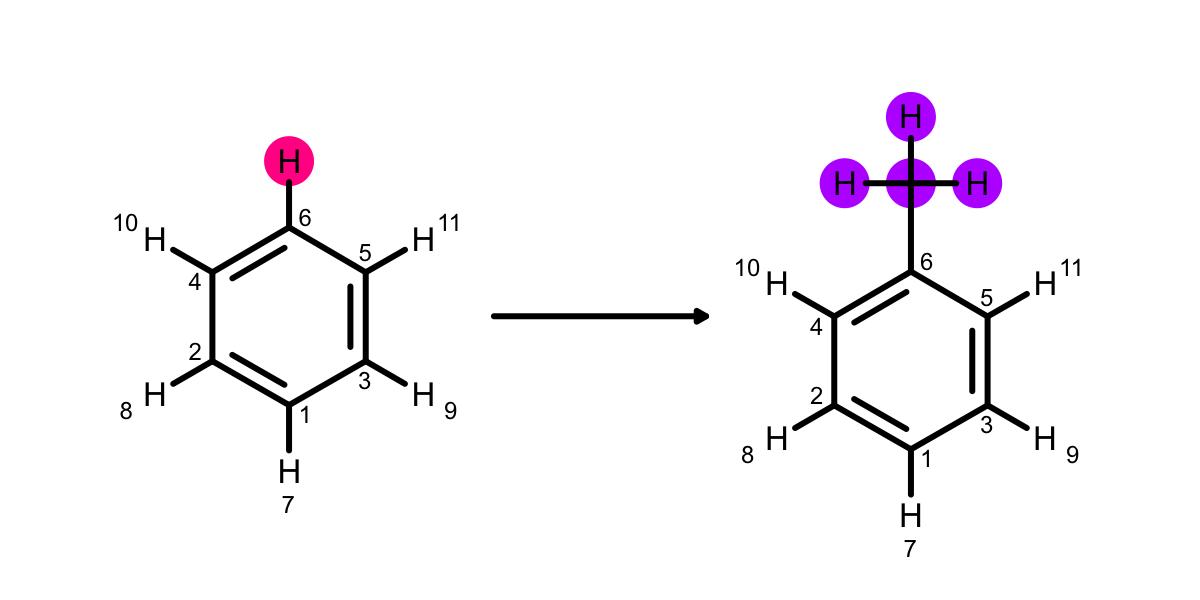

INFO:proposal_generator:Using core to chose best atom map
INFO:proposal_generator:[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
INFO:proposal_generator:Scaffold has symmetry of 12
INFO:proposal_generator:[6]
INFO:proposal_generator:[6]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:[12]
INFO:proposal_generator:12 maps are reduced to 1
INFO:proposal_generator:molecule_maps_scores: dict_keys([0.0])


benzene ---> nitrobenzene ✓


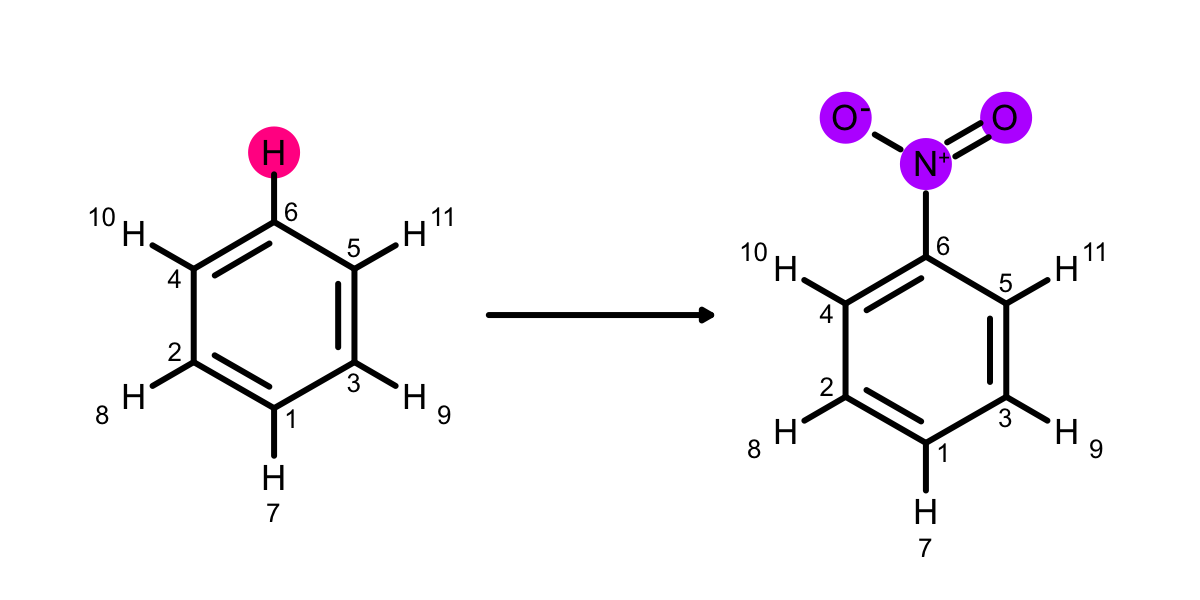

INFO:proposal_generator:Using core to chose best atom map
INFO:proposal_generator:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
INFO:proposal_generator:Scaffold has symmetry of 36
INFO:proposal_generator:[6]
INFO:proposal_generator:[6]
INFO:proposal_generator:[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
INFO:proposal_generator:[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
INFO:proposal_generator:[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

INFO:proposal_generator:[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
INFO:proposal_generator:[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
INFO:proposal_generator:[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
INFO:proposal_generator:2592 maps are reduced to 1
INFO:proposal_generator:molecule_maps_scores: dict_keys([0])
INFO:proposal_generator:Using core to chose best atom map
INFO:proposal_generator:[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
INFO:proposal_generator:Scaffold has symmetry 

Cannot map benzene to cyclohexane effectively with weak map strength
toluene ---> nitrobenzene ✓


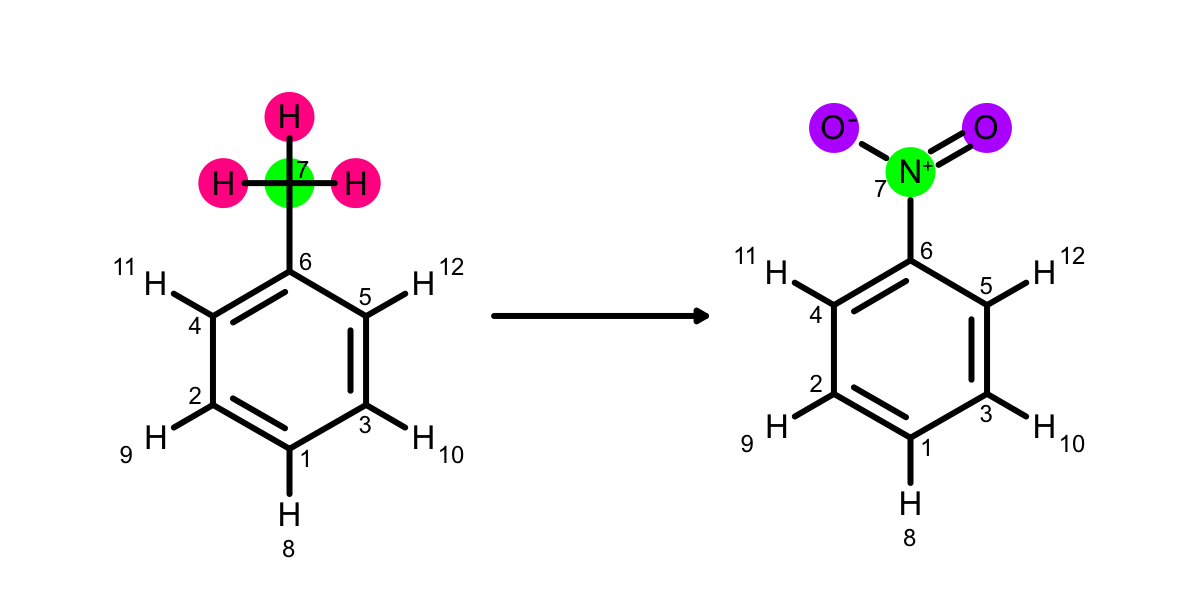

INFO:proposal_generator:Using core to chose best atom map
INFO:proposal_generator:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
INFO:proposal_generator:Scaffold has symmetry of 36
INFO:proposal_generator:[6]
INFO:proposal_generator:[6]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal_generator:[5, 5, 5, 5, 5, 5]
INFO:proposal

Cannot map toluene to cyclohexane effectively with weak map strength


INFO:proposal_generator:1080 maps are reduced to 18
INFO:proposal_generator:molecule_maps_scores: dict_keys([6.009154504591247, 12.11369504889459, 10.917346075029585, 5.73798448523496, 11.806348845850932, 10.833554232981193, 5.080636476477669, 11.149000837093642, 8.656811033463635, 4.545586024072418, 10.65012656837576, 8.18308498189786, 3.680984581826011, 8.589176152264347, 7.318483539651453, 3.2196963768576463, 8.31526612460388, 6.795870933843613])
INFO:proposal_generator:Finding best map using matching_criterion index


Cannot map nitrobenzene to cyclohexane effectively with weak map strength



In [3]:
smiles = {'benzene':'c1ccccc1','toluene':'c1ccccc1C','nitrobenzene':'C1=CC=C(C=C1)[N+](=O)[O-]','cyclohexane':'C1CCCCC1'}
list_of_mols = []
for name,smi in smiles.items():
    mol = smiles_to_oemol(smi, title=name)
    list_of_mols.append(mol)


names_and_oemols = dict(zip(smiles.keys(),list_of_mols))

# looping over default mapping strengths
for map_strength in ['weak']:
    print(f'Doing {map_strength} mapping')
    for nameA,nameB in itertools.combinations(names_and_oemols,2):
        molA = names_and_oemols[nameA]
        molB = names_and_oemols[nameB]
        mapping = AtomMapper._get_mol_atom_map(molA,molB,map_strength=map_strength)

        if mapping is None or len(mapping) < 3:
            # too many unique atoms
            print(f'Cannot map {nameA} to {nameB} effectively with {map_strength} map strength')
        else:
            print(f'{nameA} ---> {nameB} '+u'\u2713')
            render_atom_mapping(f'{nameA}to{nameB}_{map_strength}.png', molA, molB, mapping)
            i = Image(filename=f'{nameA}to{nameB}_{map_strength}.png')
            display(i)
    print()

#### Now lets try a few different mapping schemes using openeye's `OEExprOpts`

https://docs.eyesopen.com/toolkits/python/oechemtk/OEChemConstants/OEExprOpts.html

INFO:proposal_generator:Using core to chose best atom map
INFO:proposal_generator:[17, 17, 17, 17]
INFO:proposal_generator:Scaffold has symmetry of 4
INFO:proposal_generator:[22]
INFO:proposal_generator:[20]
INFO:proposal_generator:[35]
INFO:proposal_generator:[35]
INFO:proposal_generator:[34, 34, 34, 34, 34, 34, 34, 34, 34]
INFO:proposal_generator:[34, 34, 34, 34, 34, 34, 34, 34, 34]
INFO:proposal_generator:20 maps are reduced to 3
INFO:proposal_generator:molecule_maps_scores: dict_keys([12.999028162919261, 24.275168746106914, 15.035388789795533])


benzene ---> toluene ✓


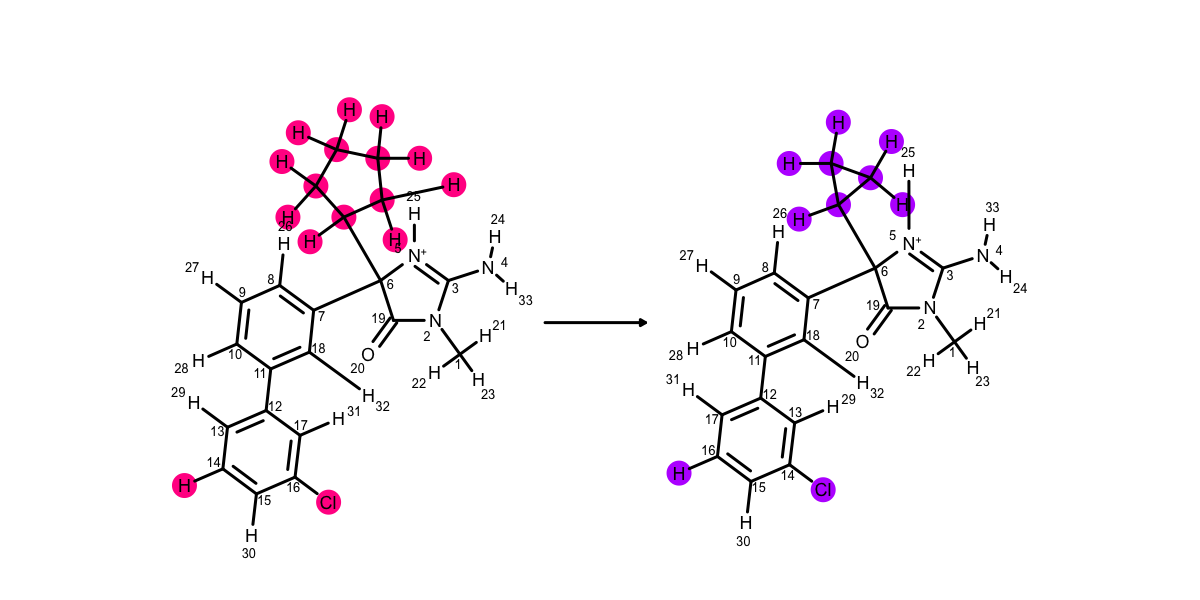

INFO:proposal_generator:Using core to chose best atom map
INFO:proposal_generator:[17, 17, 17, 17]
INFO:proposal_generator:Scaffold has symmetry of 4
INFO:proposal_generator:[22]
INFO:proposal_generator:[23]
INFO:proposal_generator:[34, 34, 34, 34, 34, 34, 34, 34, 34]
INFO:proposal_generator:[34, 34, 34, 34, 34, 34, 34, 34, 34]
INFO:proposal_generator:[35]


INFO:proposal_generator:[35]
INFO:proposal_generator:20 maps are reduced to 3
INFO:proposal_generator:molecule_maps_scores: dict_keys([21.40494471490694, 28.277624061053633, 10.441688659031954])


benzene ---> nitrobenzene ✓


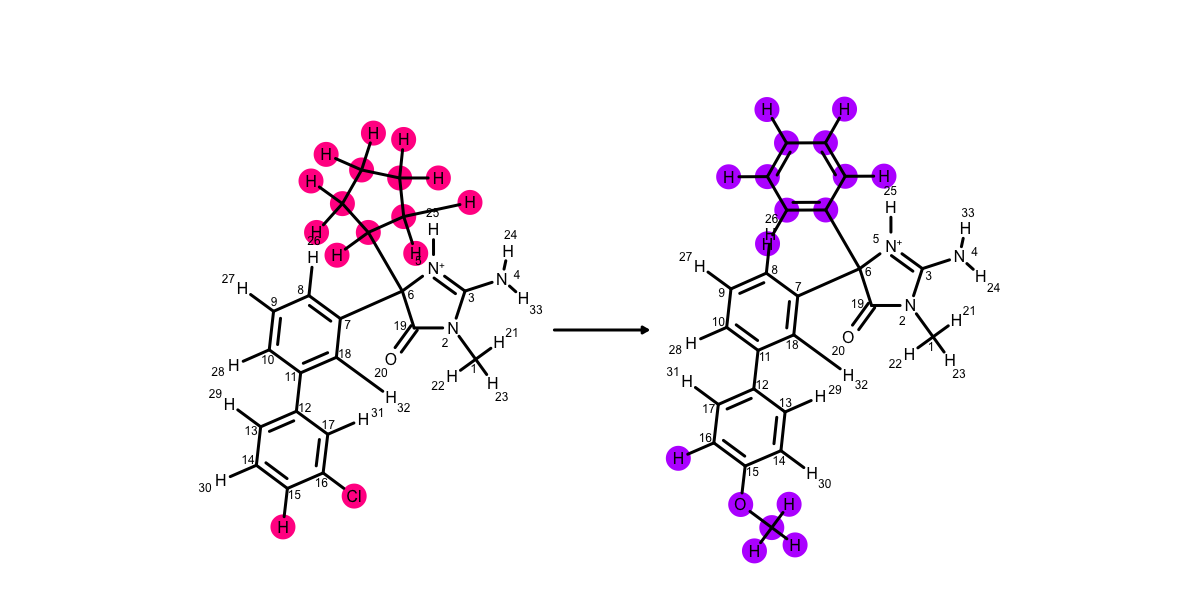

INFO:proposal_generator:Using core to chose best atom map
INFO:proposal_generator:[17, 17, 17, 17]
INFO:proposal_generator:Scaffold has symmetry of 4
INFO:proposal_generator:[22]
INFO:proposal_generator:[17]
INFO:proposal_generator:[34, 34, 34, 34, 34, 34, 34, 34, 34]
INFO:proposal_generator:[34, 34, 34, 34, 34, 34, 34, 34, 34]
INFO:proposal_generator:[35]


INFO:proposal_generator:[35]
INFO:proposal_generator:20 maps are reduced to 3
INFO:proposal_generator:molecule_maps_scores: dict_keys([24.58957426295529, 15.389125701782206, 13.230241359852048])


benzene ---> cyclohexane ✓


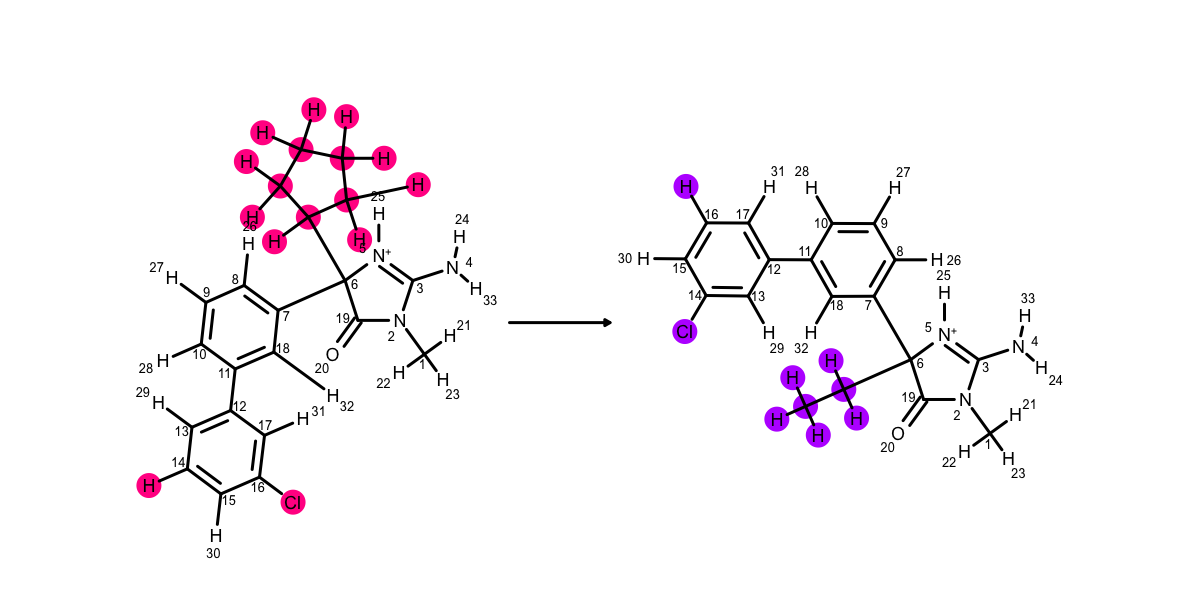

INFO:proposal_generator:Using core to chose best atom map
INFO:proposal_generator:[17, 17, 17, 17]
INFO:proposal_generator:Scaffold has symmetry of 4
INFO:proposal_generator:[20]
INFO:proposal_generator:[23]
INFO:proposal_generator:[34, 34, 34, 34, 34, 34]
INFO:proposal_generator:[34, 34, 34, 34, 34, 34]
INFO:proposal_generator:[35]


INFO:proposal_generator:[35]
INFO:proposal_generator:14 maps are reduced to 2
INFO:proposal_generator:molecule_maps_scores: dict_keys([21.36826445473162, 9.67919668582741])


toluene ---> nitrobenzene ✓


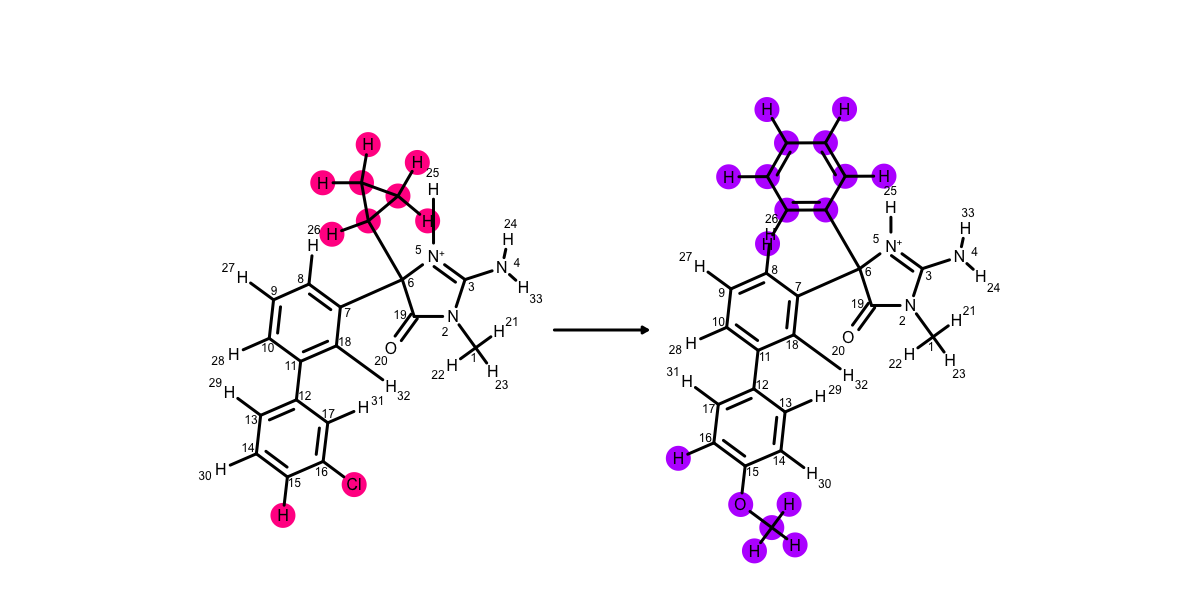

INFO:proposal_generator:Using core to chose best atom map
INFO:proposal_generator:[17, 17, 17, 17]
INFO:proposal_generator:Scaffold has symmetry of 4
INFO:proposal_generator:[20]
INFO:proposal_generator:[17]
INFO:proposal_generator:[34, 34, 34, 34, 34, 34]
INFO:proposal_generator:[34, 34, 34, 34, 34, 34]
INFO:proposal_generator:[35]
INFO:proposal_generator:[35]
INFO:proposal_generator:14 maps are reduced to 2
INFO:proposal_generator:molecule_maps_scores: dict_keys([23.3056664991967, 10.30859050151824])



toluene ---> cyclohexane ✓


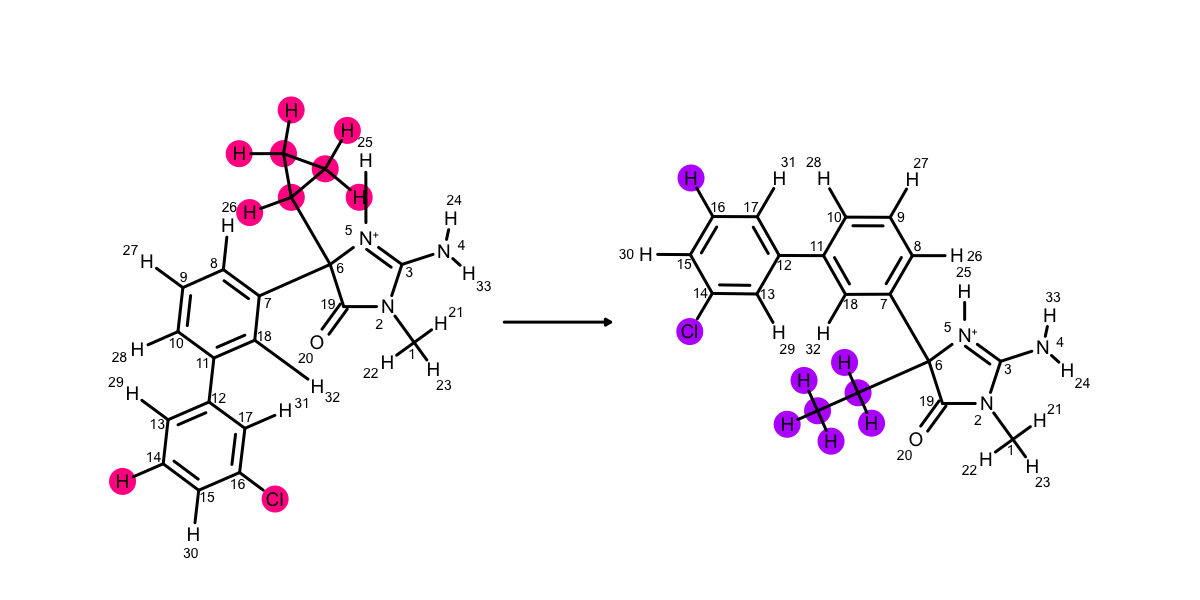

INFO:proposal_generator:Using core to chose best atom map
INFO:proposal_generator:[17, 17, 17, 17]


INFO:proposal_generator:Scaffold has symmetry of 4
INFO:proposal_generator:[23]
INFO:proposal_generator:[17]
INFO:proposal_generator:[35]
INFO:proposal_generator:[35]
INFO:proposal_generator:[35]
INFO:proposal_generator:[35]
INFO:proposal_generator:4 maps are reduced to 2
INFO:proposal_generator:molecule_maps_scores: dict_keys([9.97983797857188, 16.950330587936968])
INFO:proposal_generator:Finding best map using matching_criterion index


nitrobenzene ---> cyclohexane ✓


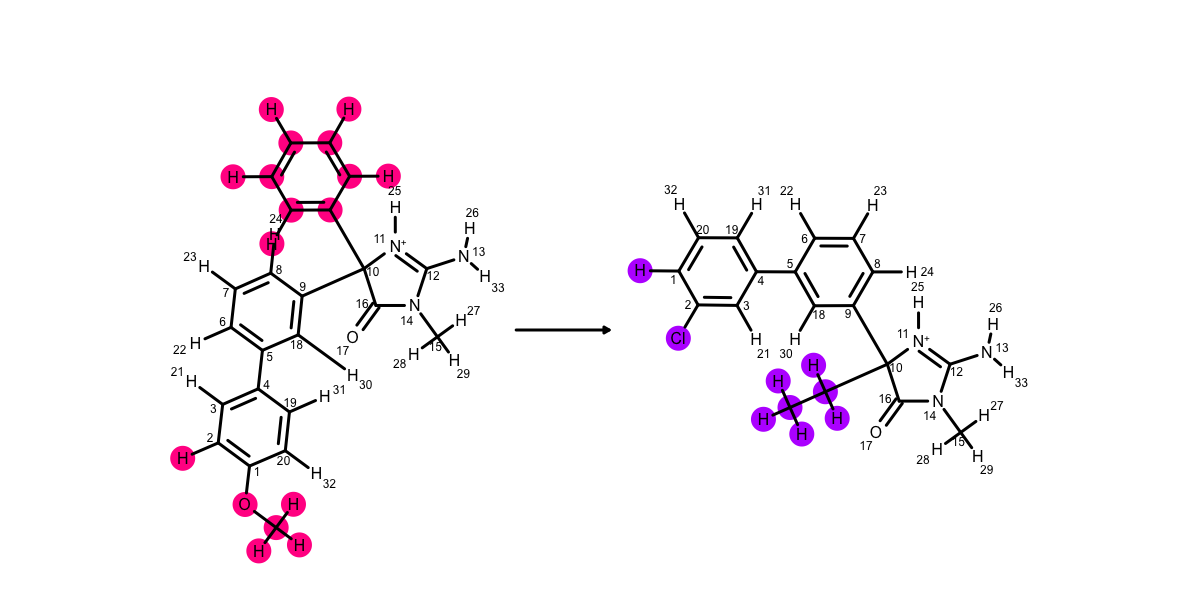

In [4]:
# this just checks atoms are in rings of the same size, with no check for aromaticity
atom_expr = oechem.OEExprOpts_IntType
bond_expr = oechem.OEExprOpts_RingMember 

from openff.toolkit.topology import Molecule
molecules = Molecule.from_file('Bace_ligands_shifted.sdf')
list_of_mols = [ molecule.to_openeye() for molecule in molecules ]

names_and_oemols = dict(zip(smiles.keys(),list_of_mols))

for nameA,nameB in itertools.combinations(names_and_oemols,2):
    molA = names_and_oemols[nameA]
    molB = names_and_oemols[nameB]    
    mapping = AtomMapper._get_mol_atom_map(molA,molB,atom_expr=atom_expr,bond_expr=bond_expr)
    
    print(f'{nameA} ---> {nameB} '+u'\u2713')
    render_atom_mapping(f'{nameA}to{nameB}.png', molA, molB, mapping)
    i = Image(filename=f'{nameA}to{nameB}.png')
    display(i)
    print()
    

Now lets look at different map_strategy's that can be used, that can prioritise different mappings

INFO:proposal_generator:Using core to chose best atom map
INFO:proposal_generator:[15, 15, 15, 15, 15, 15, 15, 15]
INFO:proposal_generator:Scaffold has symmetry of 8
INFO:proposal_generator:[15]
INFO:proposal_generator:[15]
INFO:proposal_generator:[39, 39, 39]
INFO:proposal_generator:[38]
INFO:proposal_generator:[39, 39, 39]
INFO:proposal_generator:[38]
INFO:proposal_generator:[31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
INFO:proposal_generator:[32, 32, 32, 32, 32, 32, 32, 32]
INFO:proposal_generator:[31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
INFO:proposal_generator:[32, 32, 32, 32, 32, 32, 32, 32]
INFO:proposal_generator:44 maps are reduced to 4
INFO:proposal_generator:molecule_maps_scores: dict_keys([20.791024768657902, 9.411564742065682, 107.81202665890979, 111.92886264923382])


core✓


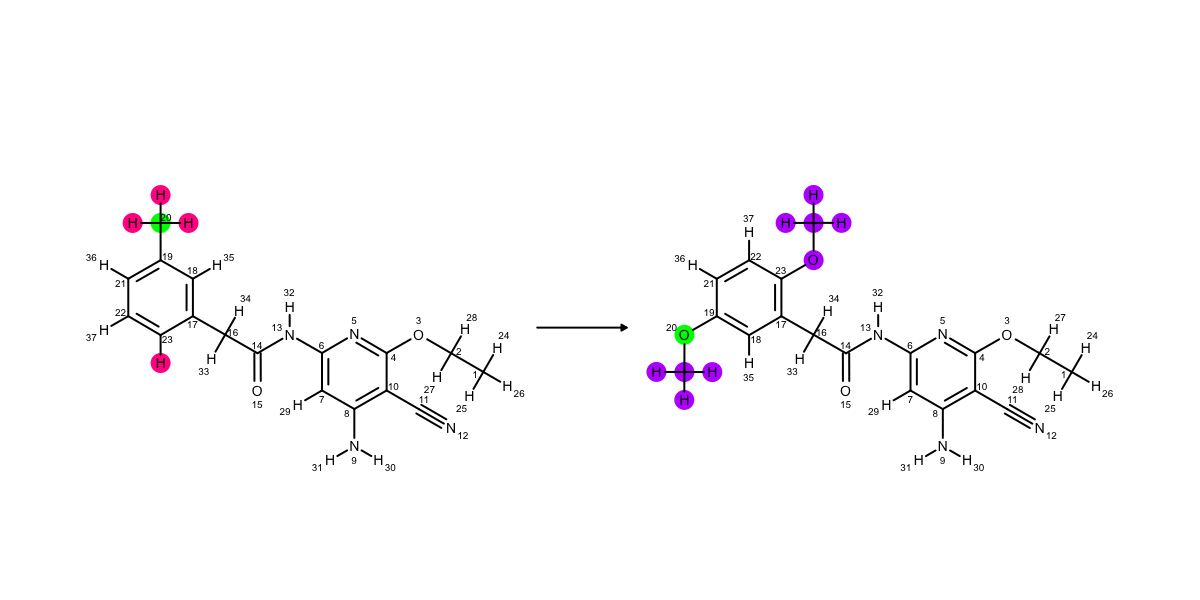

INFO:proposal_generator:Using geometry to chose best atom map
INFO:proposal_generator:[15, 15, 15, 15, 15, 15, 15, 15]
INFO:proposal_generator:Scaffold has symmetry of 8
INFO:proposal_generator:[15]
INFO:proposal_generator:[15]
INFO:proposal_generator:[39, 39, 39]
INFO:proposal_generator:[38]


INFO:proposal_generator:[39, 39, 39]
INFO:proposal_generator:[38]
INFO:proposal_generator:[31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
INFO:proposal_generator:[32, 32, 32, 32, 32, 32, 32, 32]
INFO:proposal_generator:[31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
INFO:proposal_generator:[32, 32, 32, 32, 32, 32, 32, 32]
INFO:proposal_generator:44 maps are reduced to 4
INFO:proposal_generator:molecule_maps_scores: dict_keys([20.791024768657902, 9.411564742065682, 107.81202665890979, 111.92886264923382])


geometry✓


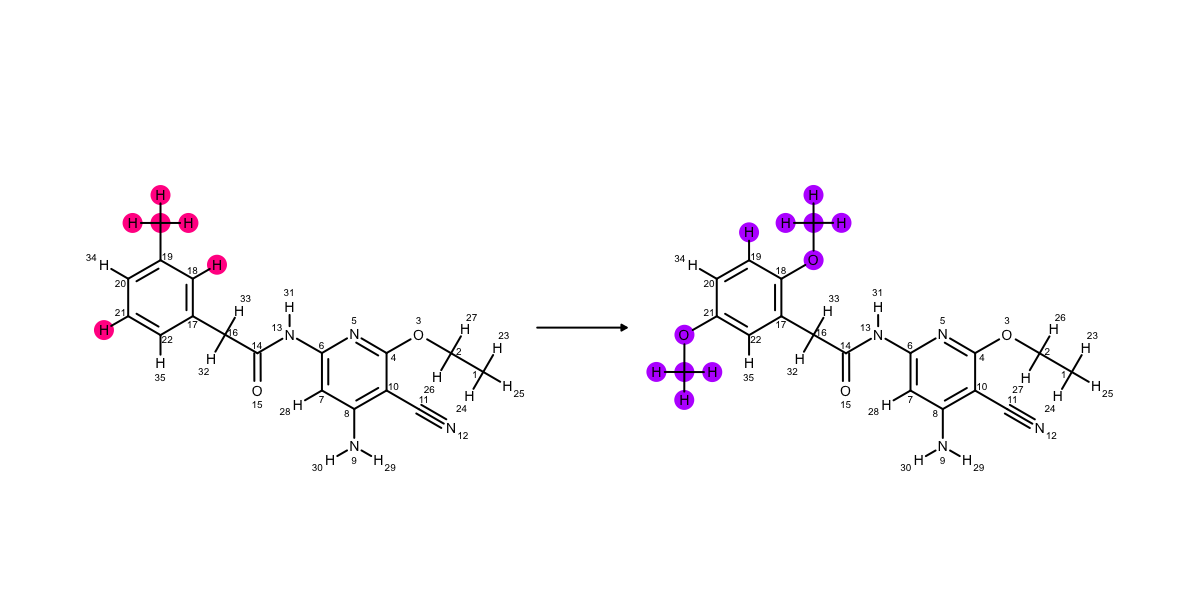

In [5]:
# this just checks atoms are in rings of the same size, with no check for aromaticity
atom_expr = oechem.OEExprOpts_IntType
bond_expr = oechem.OEExprOpts_RingMember 

from openff.toolkit.topology import Molecule
molecules = Molecule.from_file('Jnk1_ligands.sdf')
list_of_mols = [ molecule.to_openeye() for molecule in molecules ]

molA = list_of_mols[0]
molB = list_of_mols[1]

for map_strategy in ['core','geometry']: 
    mapping = AtomMapper._get_mol_atom_map(molA,molB,atom_expr=atom_expr,bond_expr=bond_expr, map_strategy=map_strategy)

    print(f'{map_strategy}'+u'\u2713')
    render_atom_mapping(f'{nameA}to{nameB}.png', molA, molB, mapping)
    i = Image(filename=f'{nameA}to{nameB}.png')
    display(i)
    print()
    

Here - trying to get as many atoms into the core as possible, maps the methyl and the ether group on to eachother. In reality, these groups point opposite directions in the binding site, and most likely won't freely interconvert in a tightly constrained active site.

Using the `geometry` as the strategy fixes this, and gets them the right way round, even though there are more unique atoms to grow in/dissapear in the simulation.

Finally lets look at all the ways that we can map. --  from best (i.e. geometrically. closest to worse)

INFO:proposal_generator:Using return-all to chose best atom map
INFO:proposal_generator:[15, 15, 15, 15, 15, 15, 15, 15]
INFO:proposal_generator:Scaffold has symmetry of 8
INFO:proposal_generator:[15]
INFO:proposal_generator:[15]
INFO:proposal_generator:[39, 39, 39]
INFO:proposal_generator:[38]
INFO:proposal_generator:[39, 39, 39]
INFO:proposal_generator:[38]
INFO:proposal_generator:[31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
INFO:proposal_generator:[32, 32, 32, 32, 32, 32, 32, 32]
INFO:proposal_generator:[31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
INFO:proposal_generator:[32, 32, 32, 32, 32, 32, 32, 32]
INFO:proposal_generator:44 maps are reduced to 4
INFO:proposal_generator:molecule_maps_scores: dict_keys([20.791024768657902, 9.411564742065682, 107.81202665890979, 111.92886264923382])


geometry score 9.41


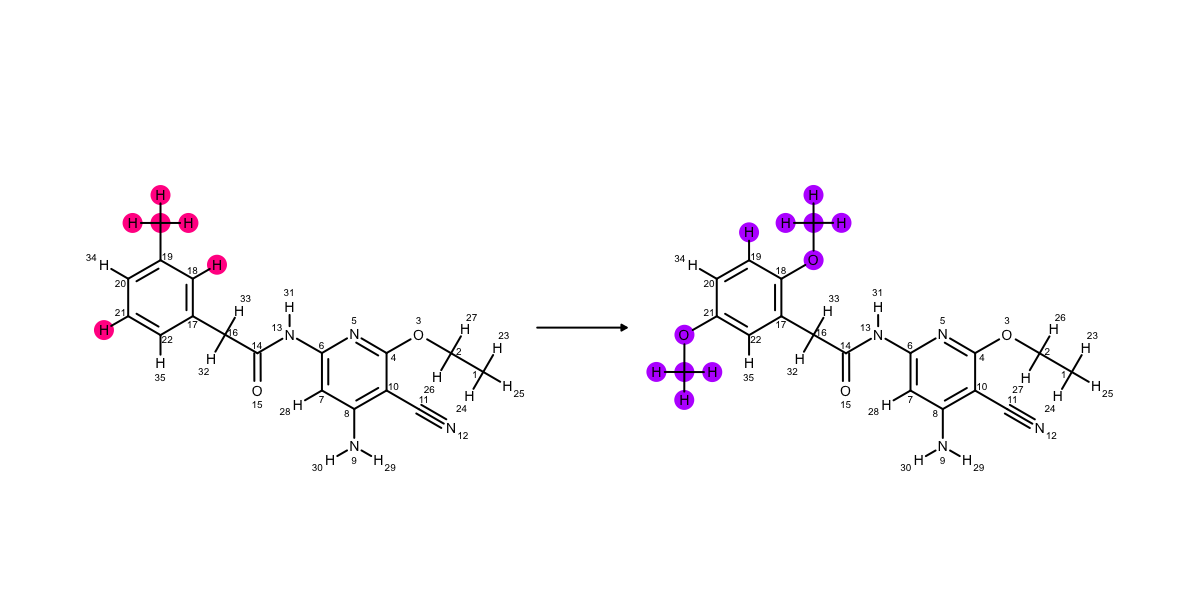


geometry score 20.79


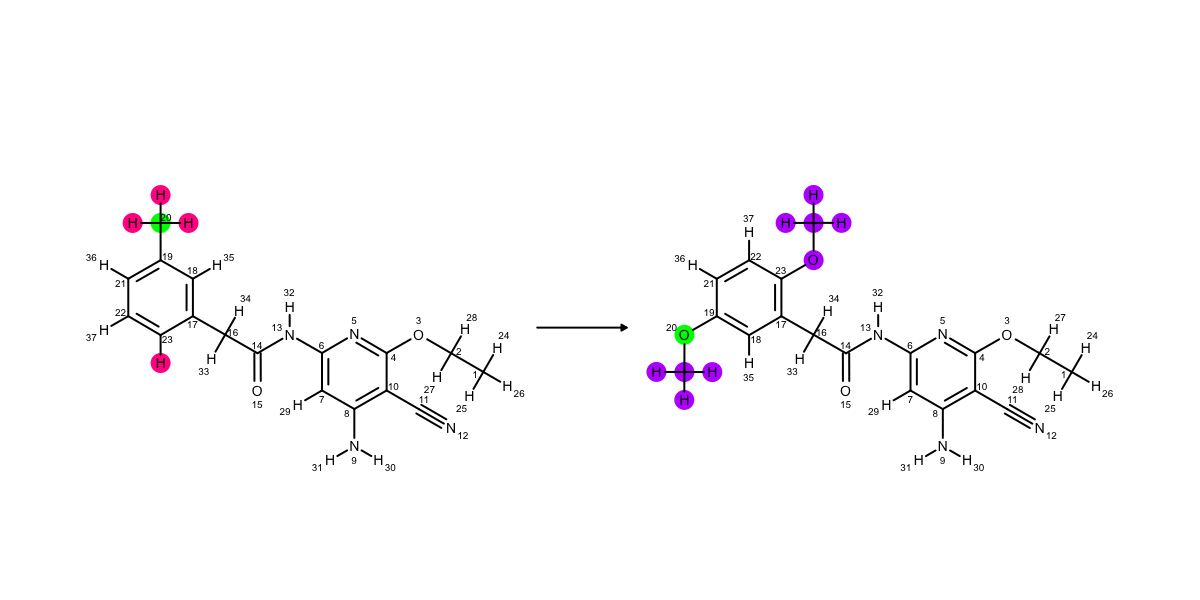


geometry score 107.81


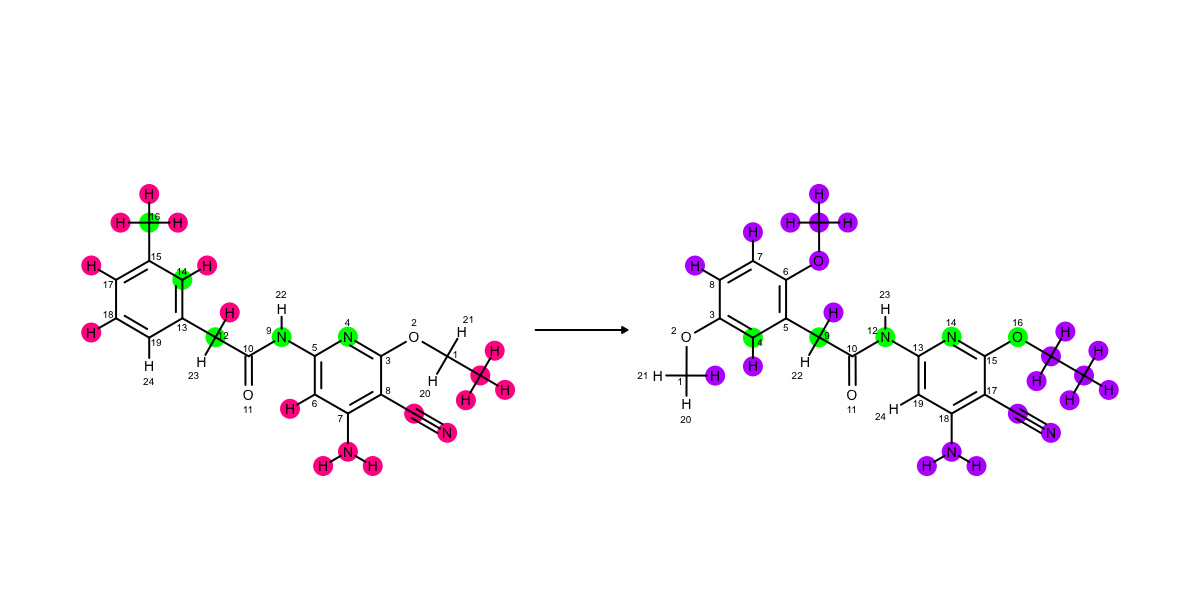


geometry score 111.93


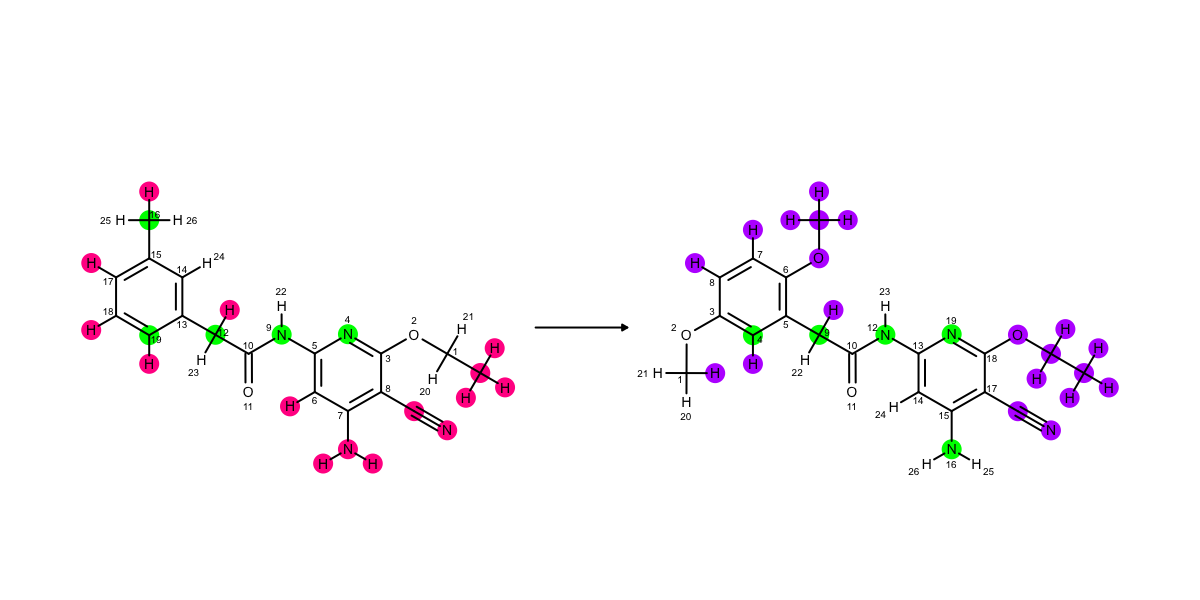

In [9]:
# this just checks atoms are in rings of the same size, with no check for aromaticity
atom_expr = oechem.OEExprOpts_IntType
bond_expr = oechem.OEExprOpts_RingMember 

from openff.toolkit.topology import Molecule
molecules = Molecule.from_file('Jnk1_ligands.sdf')
list_of_mols = [ molecule.to_openeye() for molecule in molecules ]

molA = list_of_mols[0]
molB = list_of_mols[1]

mappings = AtomMapper._get_mol_atom_map(molA,molB,atom_expr=atom_expr,bond_expr=bond_expr, map_strategy='return-all')

for score, mapping in sorted(mappings.items()):
    print(f'geometry score {score:.2f}')
    render_atom_mapping(f'{nameA}to{nameB}.png', molA, molB, mapping)
    i = Image(filename=f'{nameA}to{nameB}.png')
    display(i)
    print()

Here we see the geometrically best first, with fewer core atoms, and then we see the one with the benzene ring flipped. We can see that more is in the core, but it's further from the input coordinates.

Following these two, the mapping has found symmetry in the scaffold, and has mapped the two aromatic rings the 'wrong way around.' These are geometrically very far from the right binding mode, and have the most atoms not in the core, but in cases where the binding mode of B is very unclear, this might be an interesting experiment to run.